<a href="https://colab.research.google.com/github/AbdulSheffa/GA_CW/blob/main/GA_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import csv
import os

# --- Step 1: Generate Simulated Time Series Data ---
np.random.seed(42)
num_regions = 10
num_products = 50
time_periods = 24  # e.g., 24 months
num_warehouses = 3

In [ ]:
# Simulate time-series demand data
time_series_data = []
for r in range(1, num_regions + 1):
    for p in range(1, num_products + 1):
        base_demand = np.random.randint(200, 800)
        trend = np.linspace(0, 100, time_periods)  # Trend
        seasonality = 50 * np.sin(np.linspace(0, 2 * np.pi, time_periods))  # Seasonality
        noise = np.random.normal(0, 30, time_periods)  # Random noise
        demand = base_demand + trend + seasonality + noise
        time_series_data.append({
            "Region": r,
            "Product": p,
            "Time": list(range(1, time_periods + 1)),
            "Demand": demand
        })

# Convert to DataFrame
time_series_df = pd.concat([pd.DataFrame(data) for data in time_series_data], ignore_index=True)
print(time_series_df)

       Region  Product  Time      Demand
0           1        1     1  285.492965
1           1        1     2  335.300657
2           1        1     3  350.890675
3           1        1     4  392.638780
4           1        1     5  336.280760
...       ...      ...   ...         ...
11995      10       50    20  480.651966
11996      10       50    21  538.856236
11997      10       50    22  548.984675
11998      10       50    23  545.053912
11999      10       50    24  642.194640

[12000 rows x 4 columns]


In [3]:
# Load the dataset
time_series_df = pd.read_csv('/content/drive/My Drive/CI/constant_time_series_demand.csv')



       Region  Product  Time      Demand
0           1        1     1  285.492965
1           1        1     2  335.300657
2           1        1     3  350.890675
3           1        1     4  392.638780
4           1        1     5  336.280760
...       ...      ...   ...         ...
11995      10       50    20  480.651966
11996      10       50    21  538.856236
11997      10       50    22  548.984675
11998      10       50    23  545.053912
11999      10       50    24  642.194640

[12000 rows x 4 columns]


In [ ]:
# --- Step 2: Prepare Data for LSTM ---
scaler = MinMaxScaler(feature_range=(0, 1))

def prepare_lstm_data(region, product, seq_length=12):
    # Filter data for the specific region-product pair
    subset = time_series_df[(time_series_df["Region"] == region) & (time_series_df["Product"] == product)]
    demand = subset["Demand"].values.reshape(-1, 1)

    # Normalize data
    demand_scaled = scaler.fit_transform(demand)

    # Create sequences
    X, y = [], []
    for i in range(len(demand_scaled) - seq_length):
        X.append(demand_scaled[i:i + seq_length])
        y.append(demand_scaled[i + seq_length])
    return np.array(X), np.array(y)

# Example Data for Region 1, Product 1
seq_length = 12
X_train, y_train = prepare_lstm_data(region=1, product=1, seq_length=seq_length)



# --- Step 3: Build and Train LSTM Model ---
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation="relu", input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Train LSTM for Region 1, Product 1
model = build_lstm_model((seq_length, 1))
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Forecast Function
def forecast_lstm(region, product, seq_length=12):
    X, _ = prepare_lstm_data(region, product, seq_length=seq_length)
    last_sequence = X[-1].reshape(1, seq_length, 1)
    prediction_scaled = model.predict(last_sequence)
    prediction = scaler.inverse_transform(prediction_scaled)
    return prediction[0, 0]

# Forecast for All Region-Product Pairs
forecasted_demand = []
for region in range(1, num_regions + 1):
    for product in range(1, num_products + 1):
        forecast = forecast_lstm(region, product)
        forecasted_demand.append({"Region": region, "Product": product, "Forecasted_Demand": forecast})

forecasted_demand_df = pd.DataFrame(forecasted_demand)
forecasted_demand_df.to_csv('/content/drive/My Drive/CI/forecasted_demand_df.csv', index=False)



print(forecasted_demand_df)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2260
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2198
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2139
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2080
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2022
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1965
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1909
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1856
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1803
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1752
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1702
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1653
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1605
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1557
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1510
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/st

In [ ]:

# --- Step 4: Generate Simulated Warehouse and Transport Data ---
np.random.seed(42)
warehouse_df = pd.DataFrame({
    "Warehouse_ID": range(1, num_warehouses + 1),
    "Capacity": np.random.randint(1000, 5000, num_warehouses),
    "Current_Stock": np.random.randint(500, 2000, num_warehouses),
    "Holding_Cost": np.random.uniform(1, 5, num_warehouses),
})

transport_costs = []
for i in range(1, num_warehouses + 1):
    for j in range(1, num_warehouses + 1):
        if i != j:
            transport_costs.append({
                "From_Warehouse": i,
                "To_Warehouse": j,
                "Cost_Per_Unit": np.random.uniform(2, 10)
            })

transport_df = pd.DataFrame(transport_costs)
print(transport_df.head(5))

print(warehouse_df.head(5))


warehouse_df.to_csv('/content/drive/My Drive/CI/simulated_warehouse_data.csv', index=False)
transport_df.to_csv('/content/drive/My Drive/CI/simulated_transport_data.csv', index=False)


   From_Warehouse  To_Warehouse  Cost_Per_Unit
0               1             2       2.464669
1               1             3       8.929409
2               2             1       6.808920
3               2             3       7.664581
4               3             1       2.164676
   Warehouse_ID  Capacity  Current_Stock  Holding_Cost
0             1      4174           1794      3.394634
1             2      4507           1630      1.624075
2             3      1860           1595      1.623978


In [4]:
warehouse_df = pd.read_csv('/content/drive/My Drive/CI CW/simulated_warehouse_data.csv')
transport_df = pd.read_csv('/content/drive/My Drive/CI CW/simulated_transport_data.csv')
forecasted_demand_df = pd.read_csv('/content/drive/My Drive/CI CW/forecasted_demand_df.csv')


In [7]:
# Define the file path in Google Drive
drive_csv_path = '/content/drive/My Drive/CI/CW/Best_strategy_results.csv'


# Create the CSV file with headers
headers = ["Strategy Name", "Best Fitness Value","Generations","Population"]
with open(drive_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)

print(f"CSV file created with headers at: {drive_csv_path}")


CSV file created with headers at: /content/drive/My Drive/CI/CW/Best_strategy_results.csv



Running GA for 50 Generations and Population Size 50
  Running strategy: Tournament + Two-Point


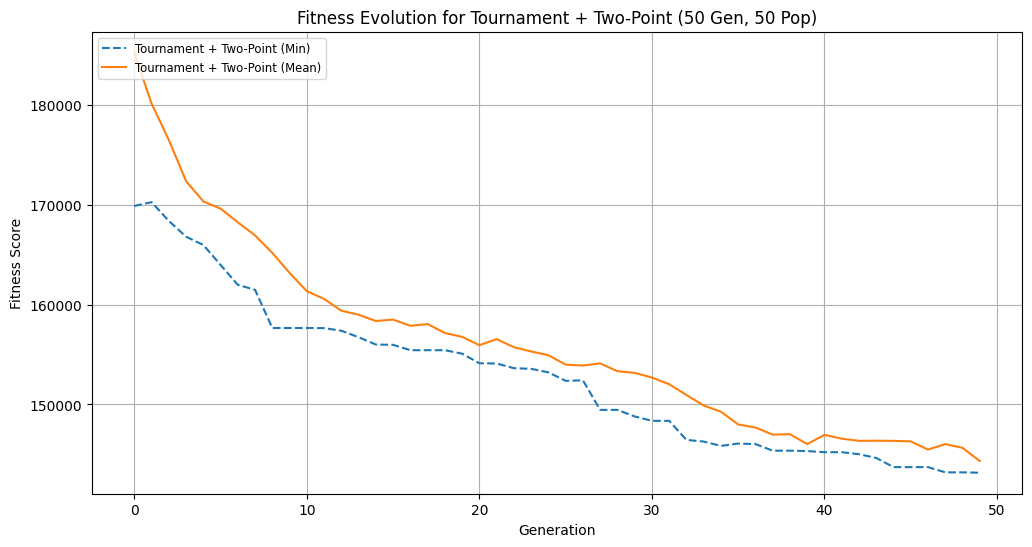

  Running strategy: Roulette + Blend


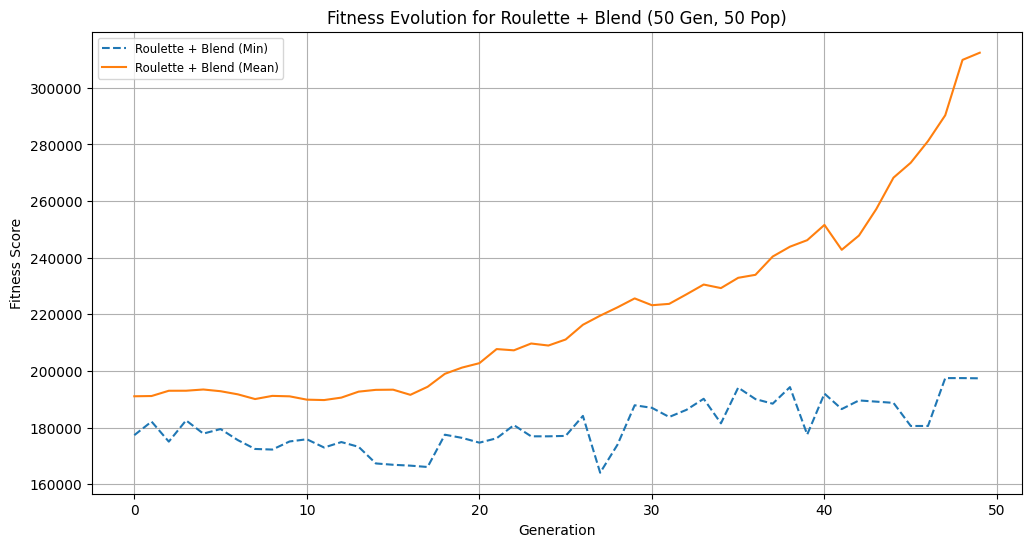

  Running strategy: Rank-Based + Uniform


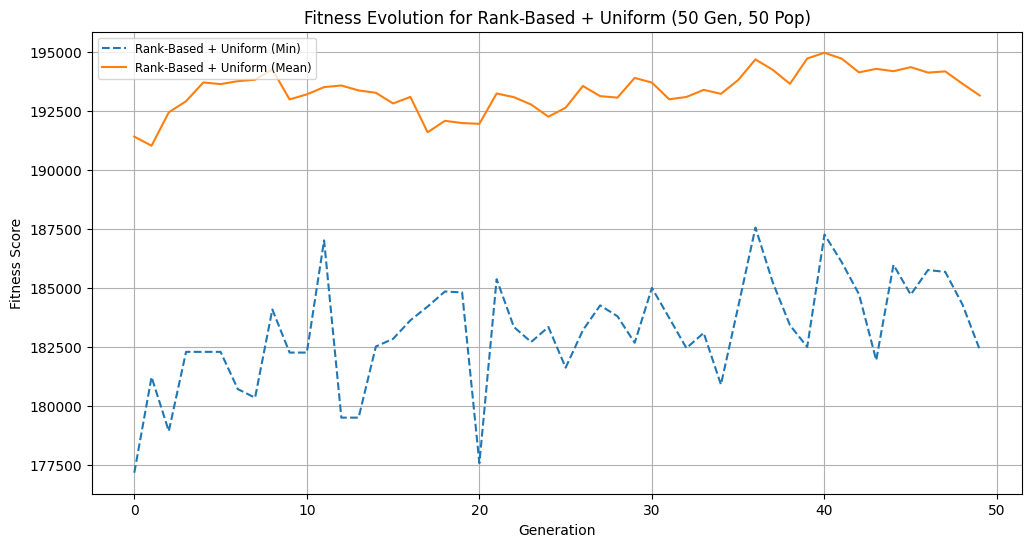

  Running strategy: Tournament + Multi-Point


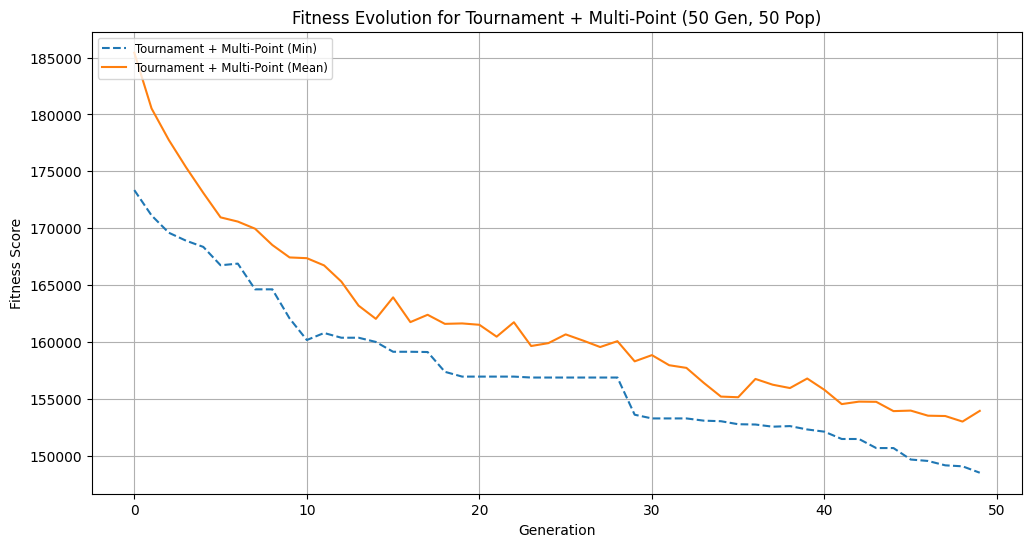

  Running strategy: Roulette + One-Point


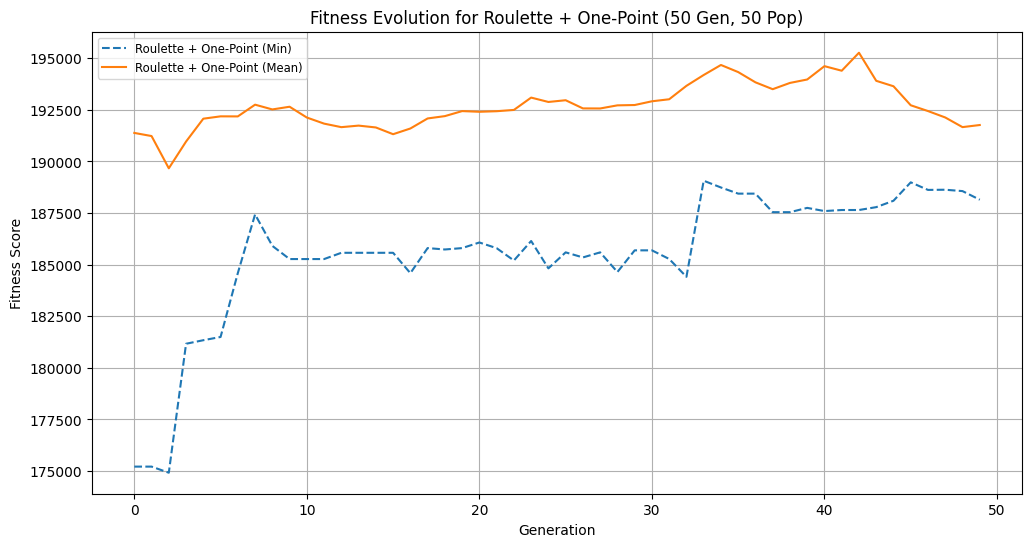


Running GA for 50 Generations and Population Size 100
  Running strategy: Tournament + Two-Point


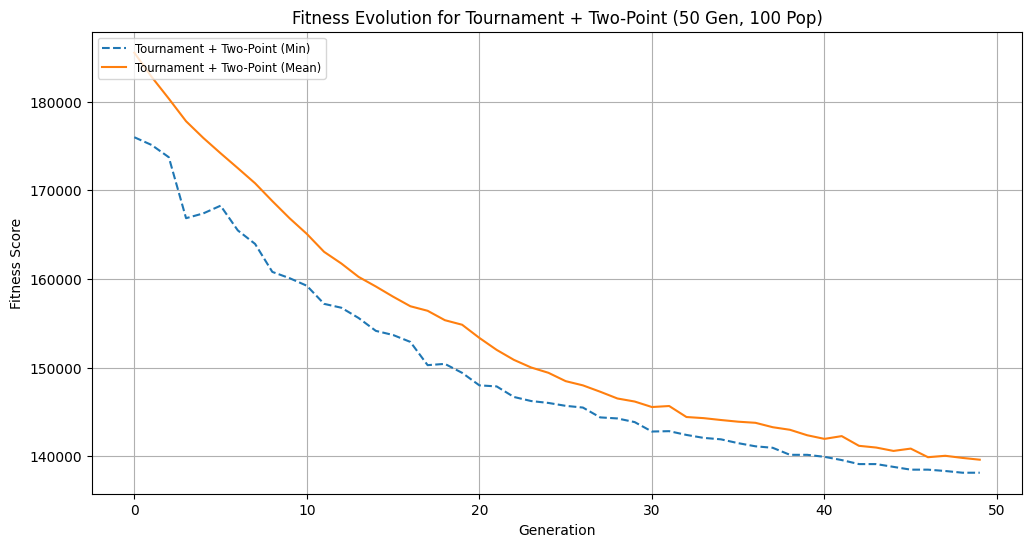

  Running strategy: Roulette + Blend


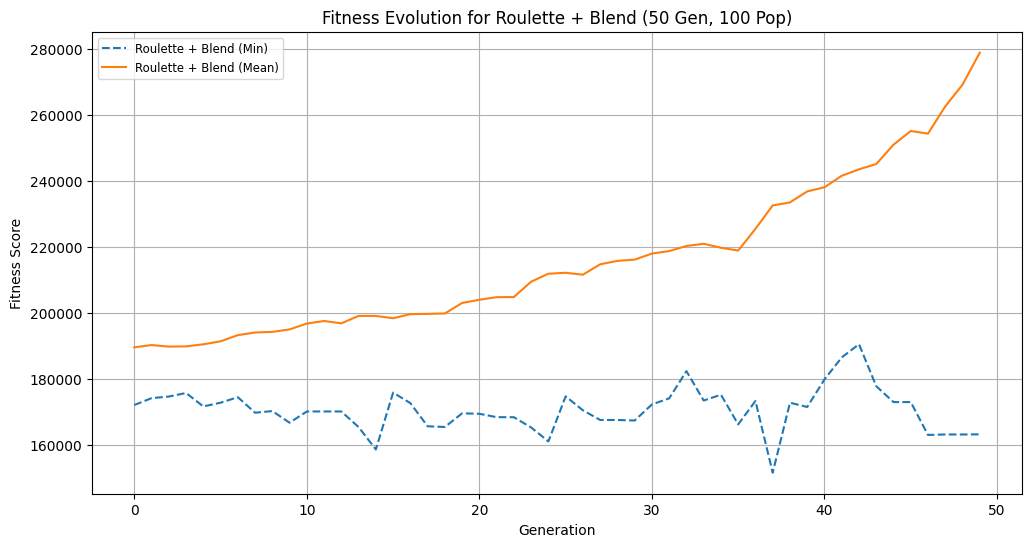

  Running strategy: Rank-Based + Uniform


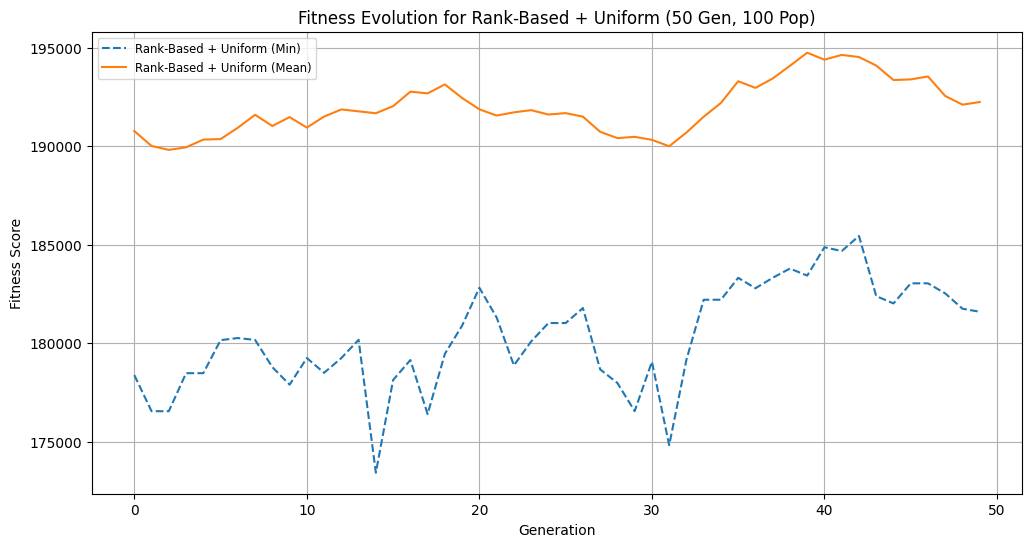

  Running strategy: Tournament + Multi-Point


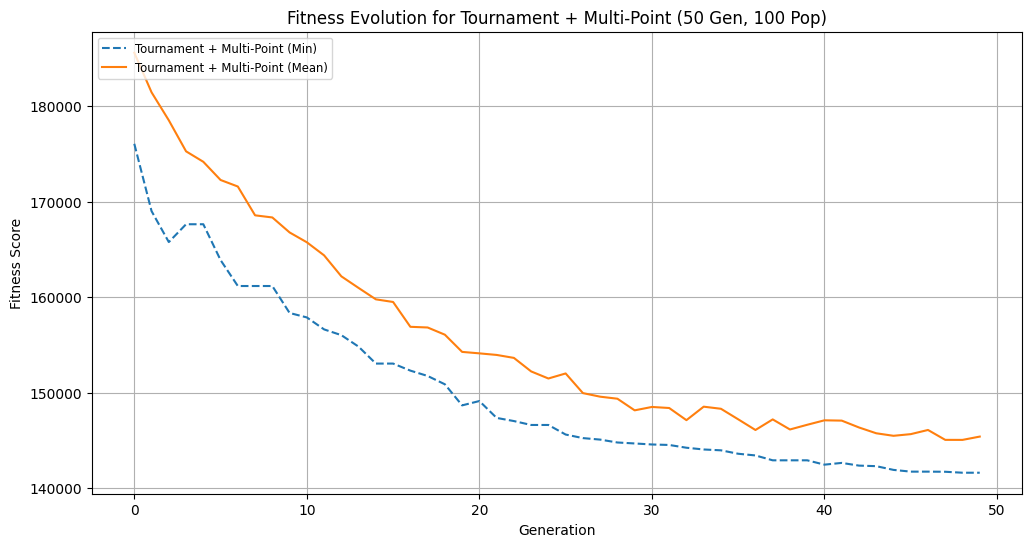

  Running strategy: Roulette + One-Point


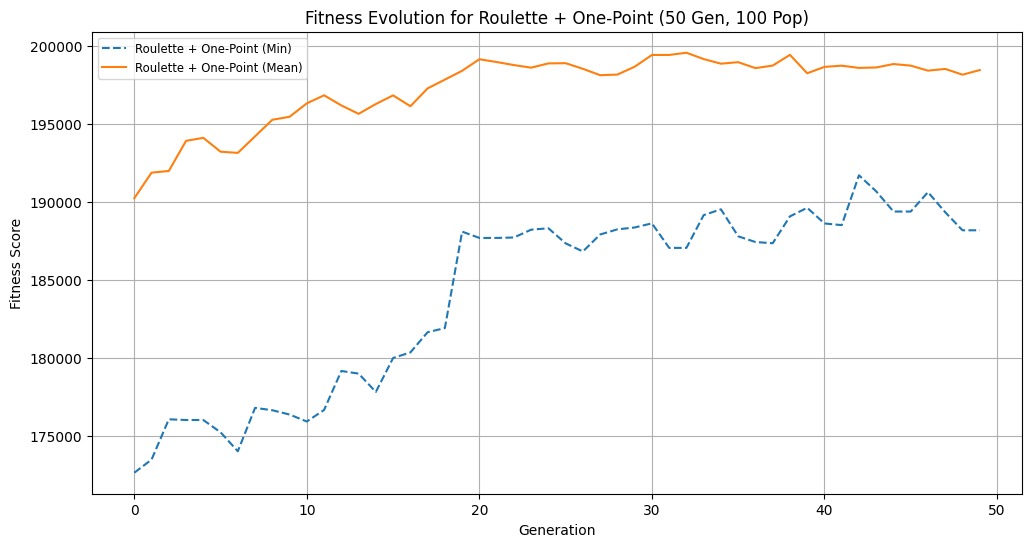


Running GA for 50 Generations and Population Size 200
  Running strategy: Tournament + Two-Point


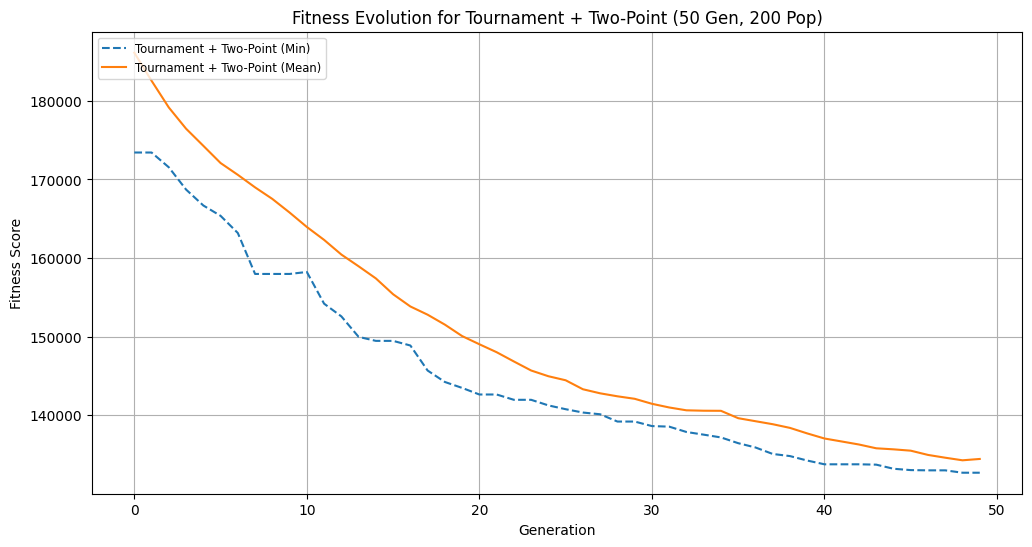

  Running strategy: Roulette + Blend


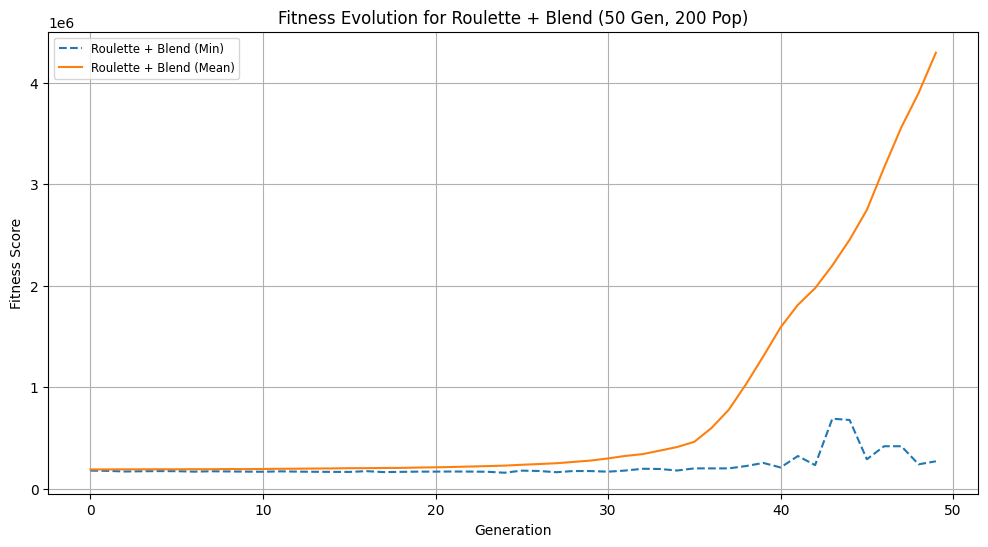

  Running strategy: Rank-Based + Uniform


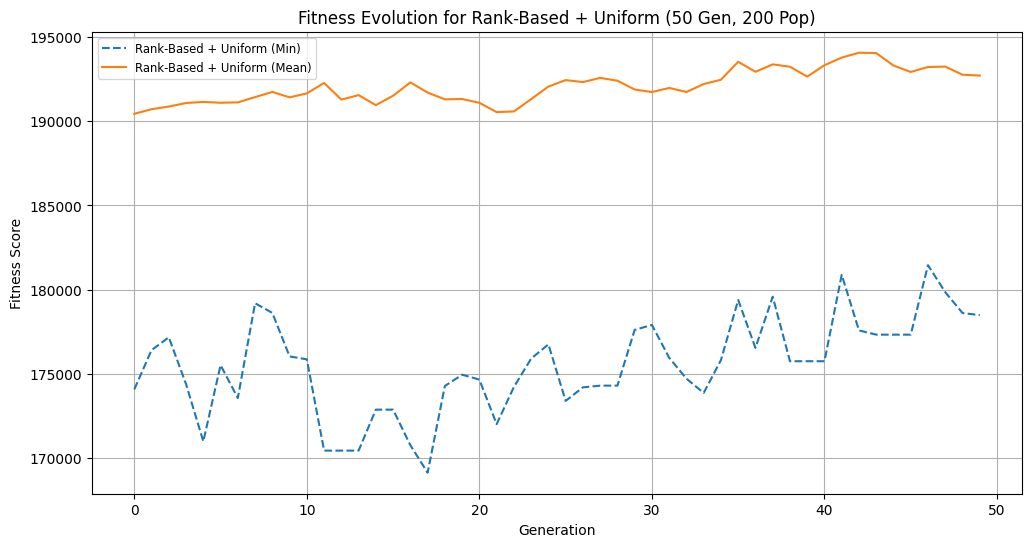

  Running strategy: Tournament + Multi-Point


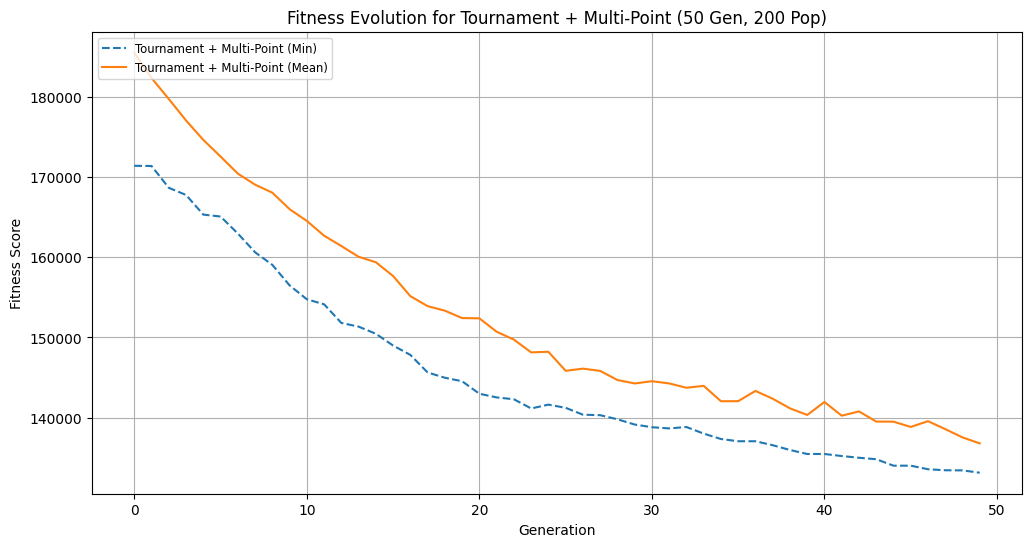

  Running strategy: Roulette + One-Point


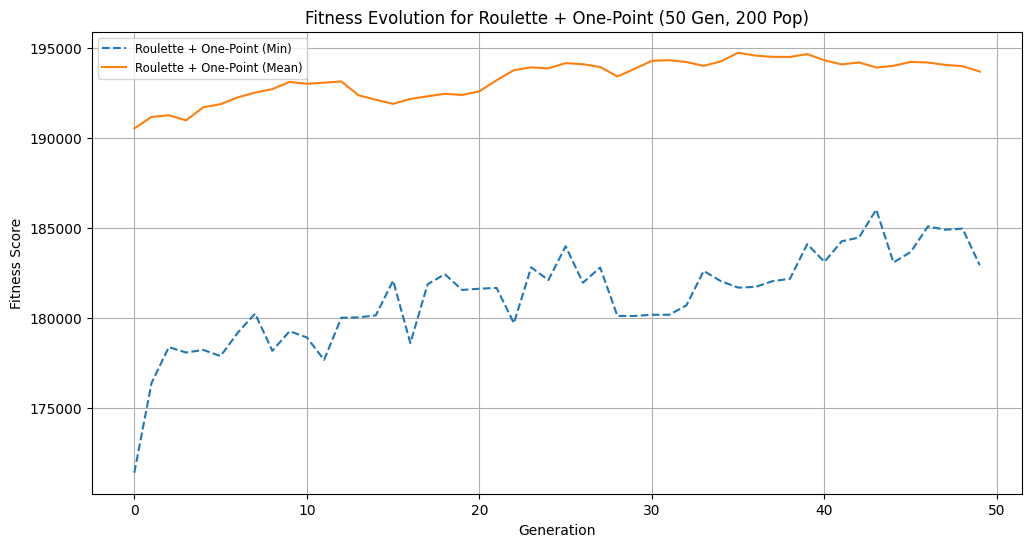


Running GA for 50 Generations and Population Size 300
  Running strategy: Tournament + Two-Point


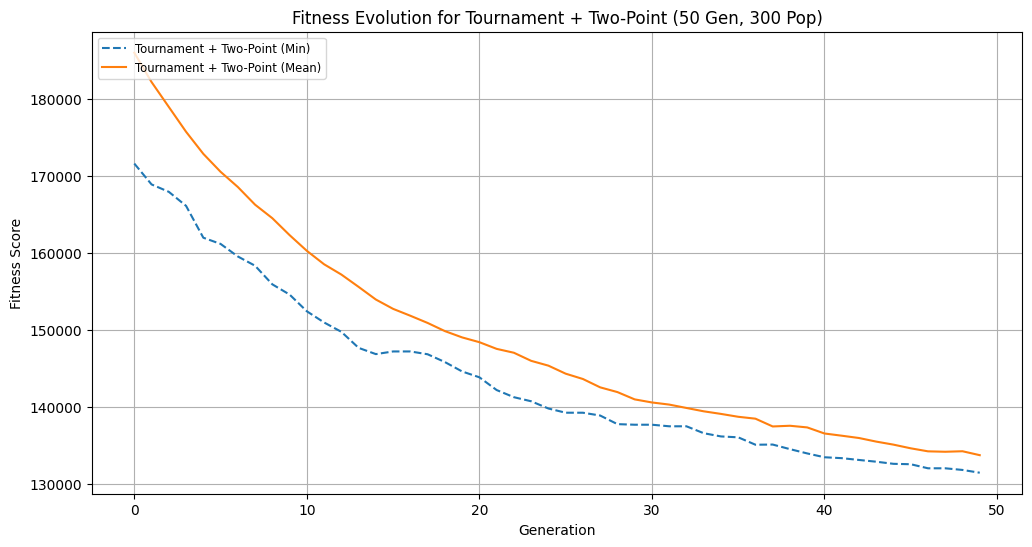

  Running strategy: Roulette + Blend


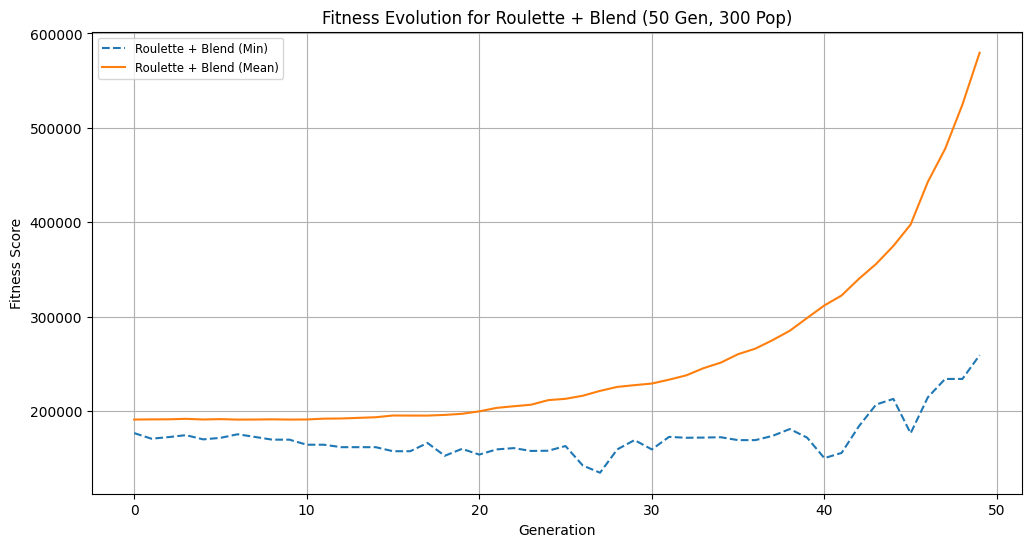

  Running strategy: Rank-Based + Uniform


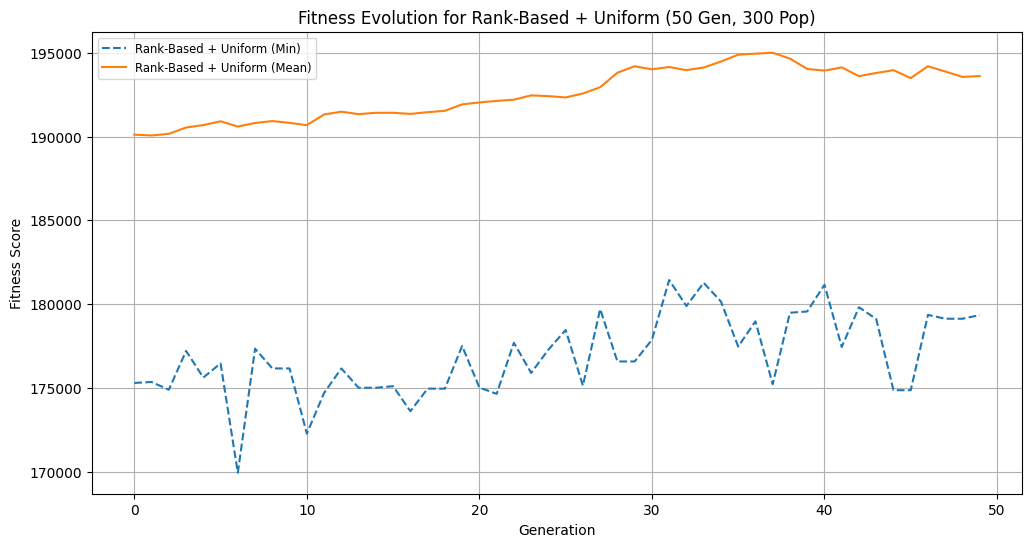

  Running strategy: Tournament + Multi-Point


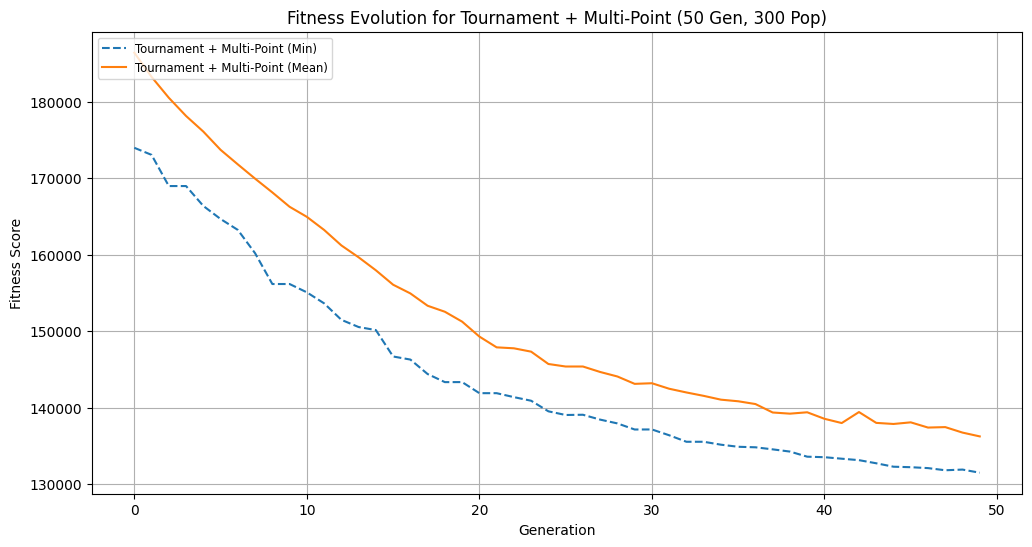

  Running strategy: Roulette + One-Point


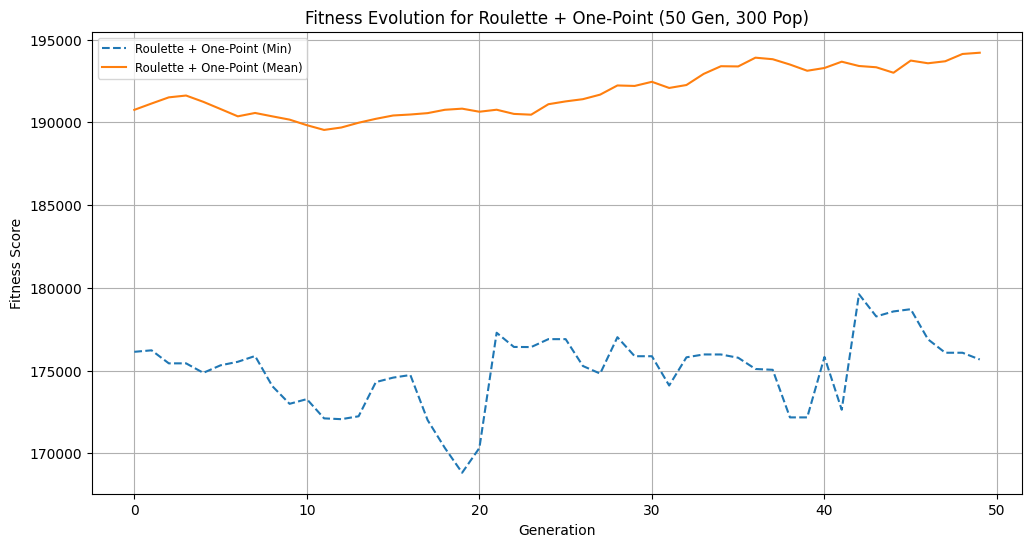


Running GA for 100 Generations and Population Size 50
  Running strategy: Tournament + Two-Point


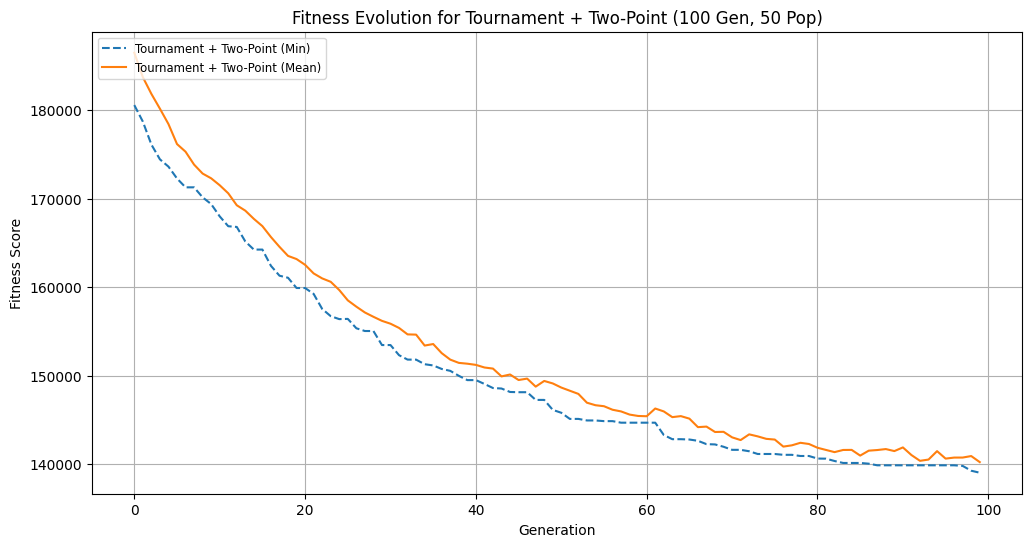

  Running strategy: Roulette + Blend


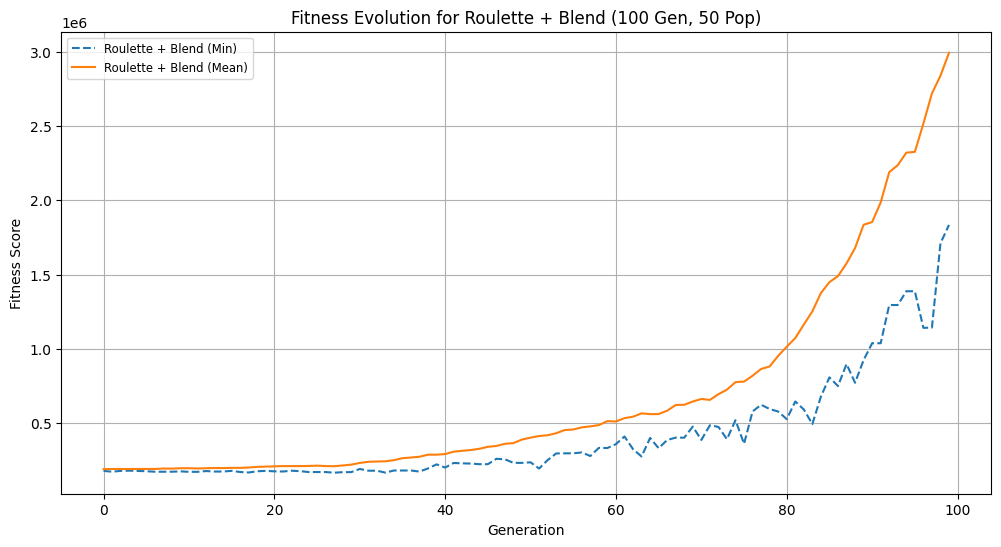

  Running strategy: Rank-Based + Uniform


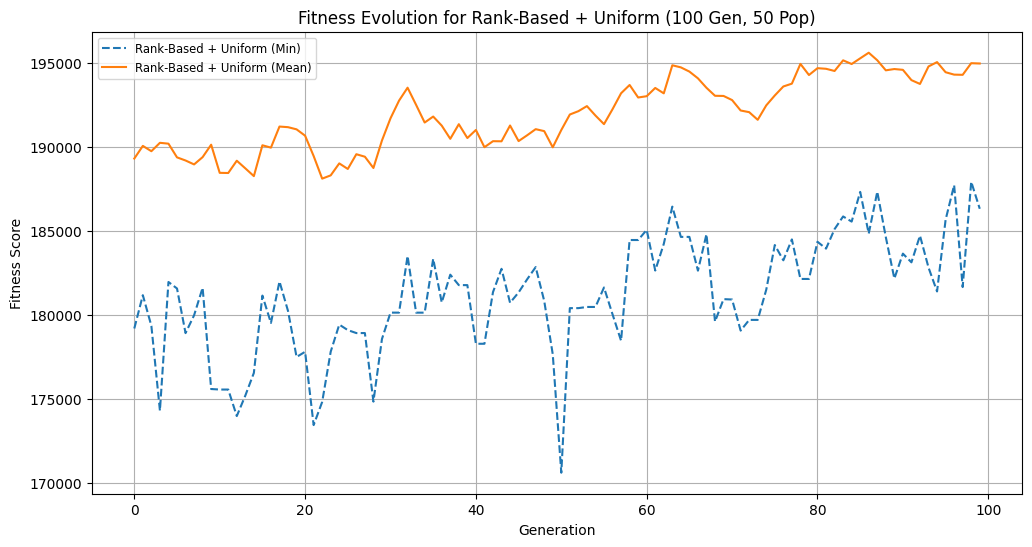

  Running strategy: Tournament + Multi-Point


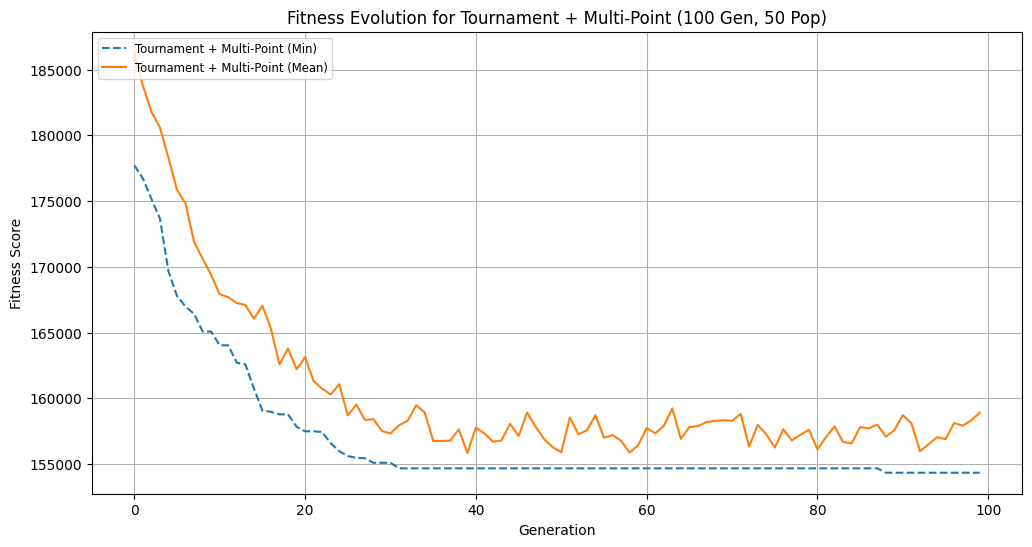

  Running strategy: Roulette + One-Point


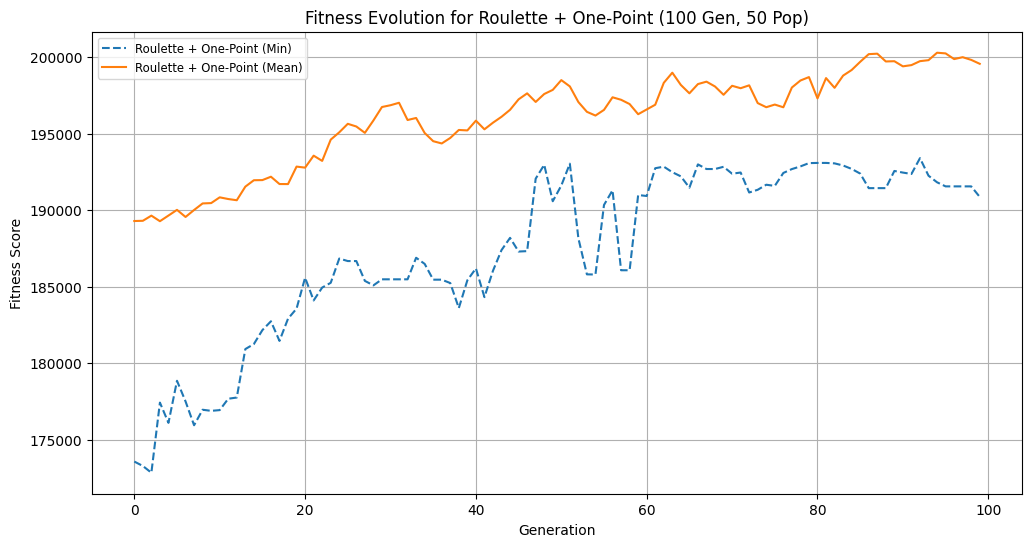


Running GA for 100 Generations and Population Size 100
  Running strategy: Tournament + Two-Point


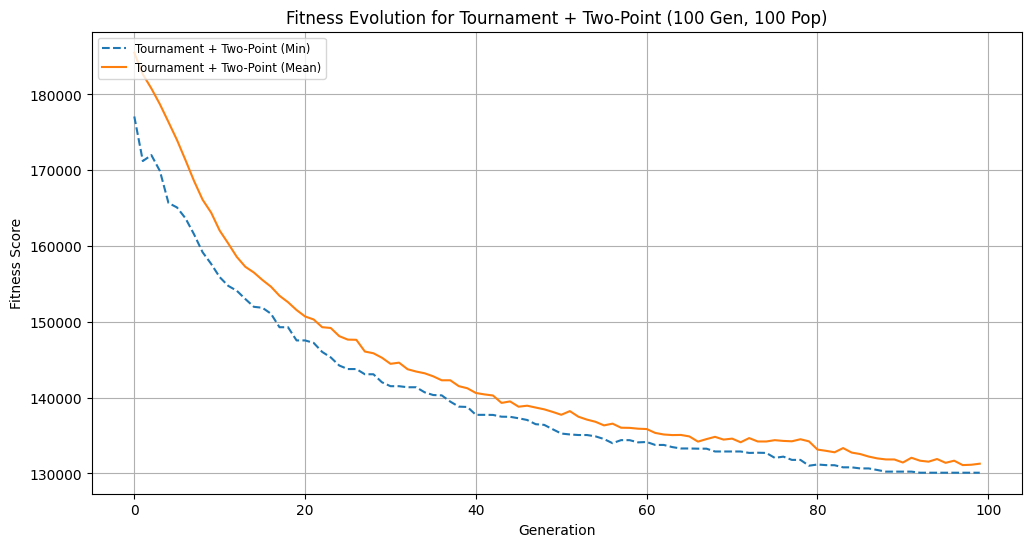

  Running strategy: Roulette + Blend


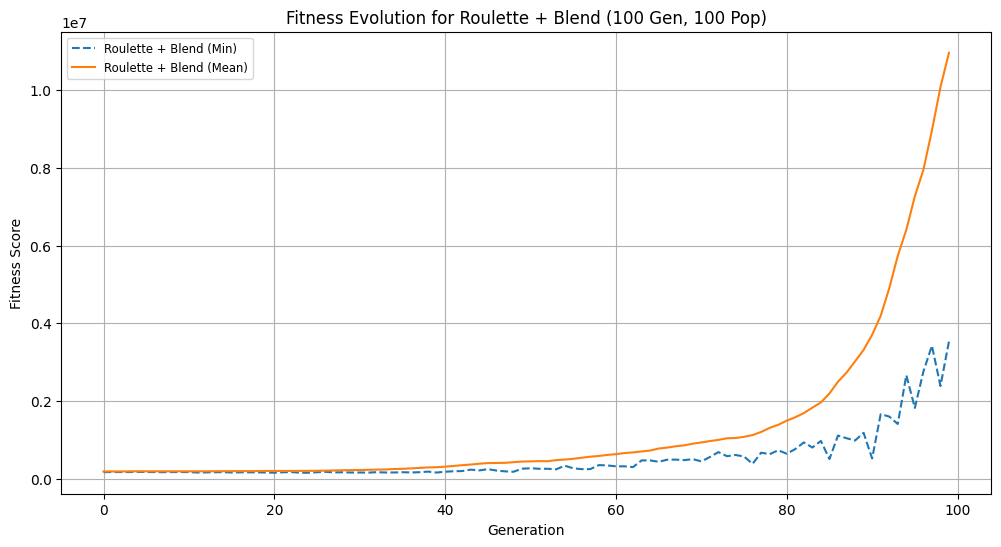

  Running strategy: Rank-Based + Uniform


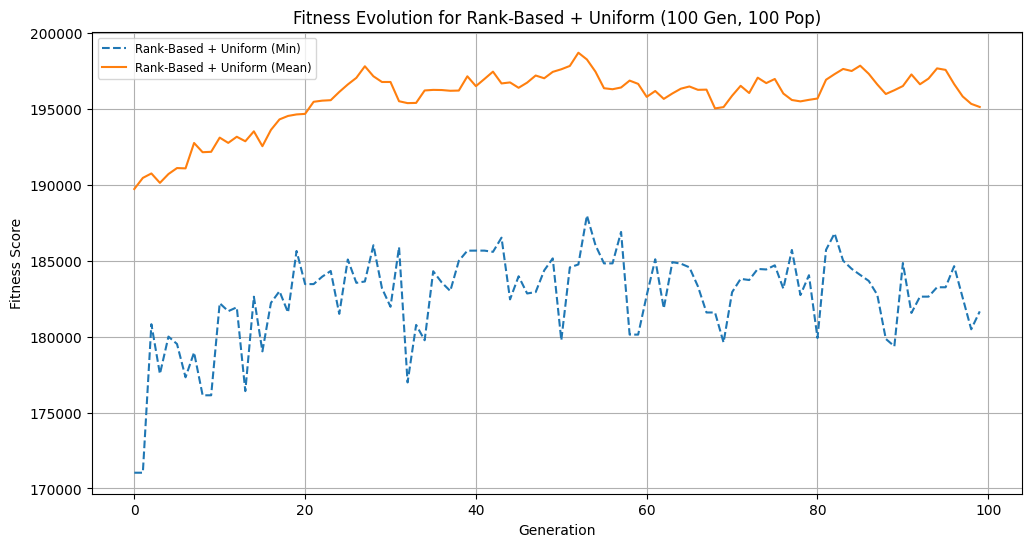

  Running strategy: Tournament + Multi-Point


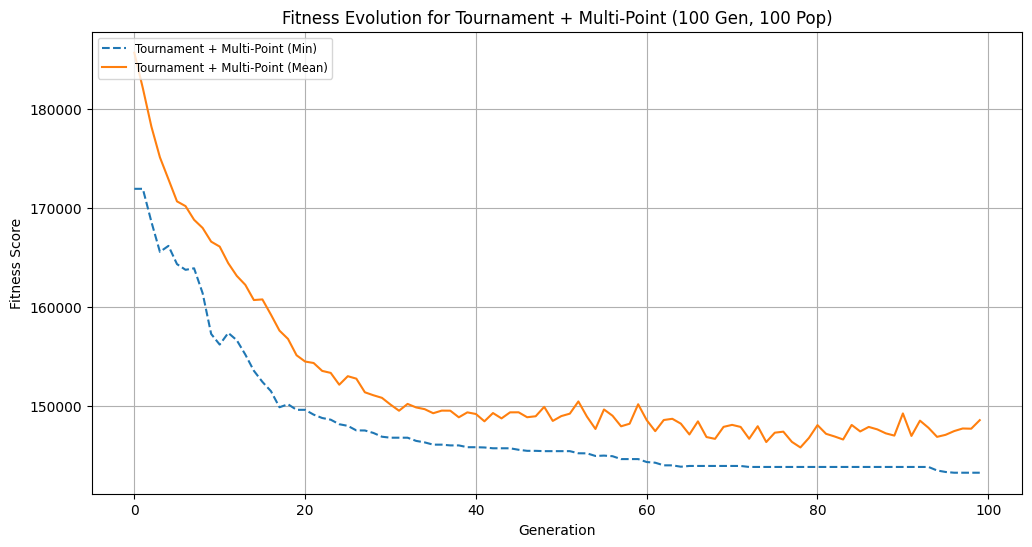

  Running strategy: Roulette + One-Point


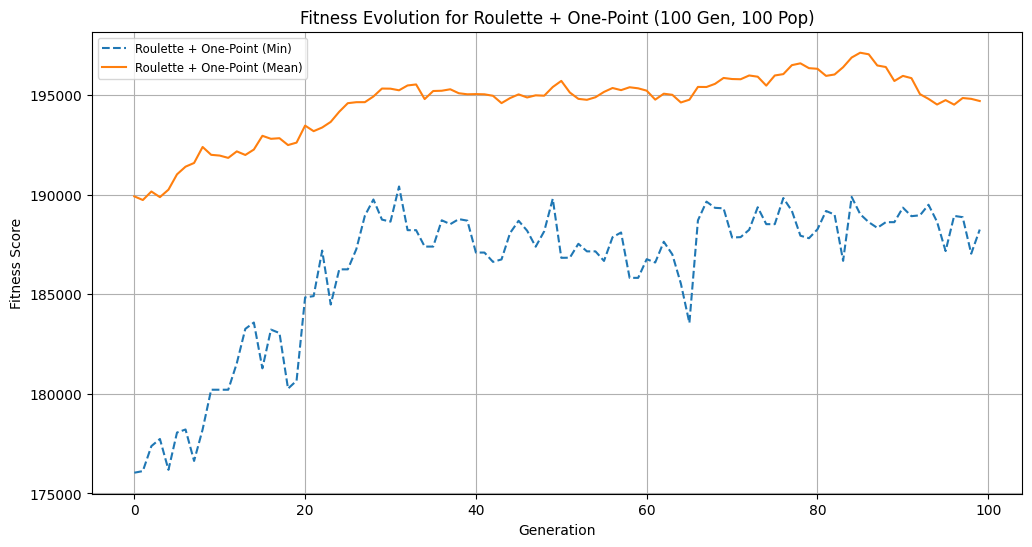


Running GA for 100 Generations and Population Size 200
  Running strategy: Tournament + Two-Point


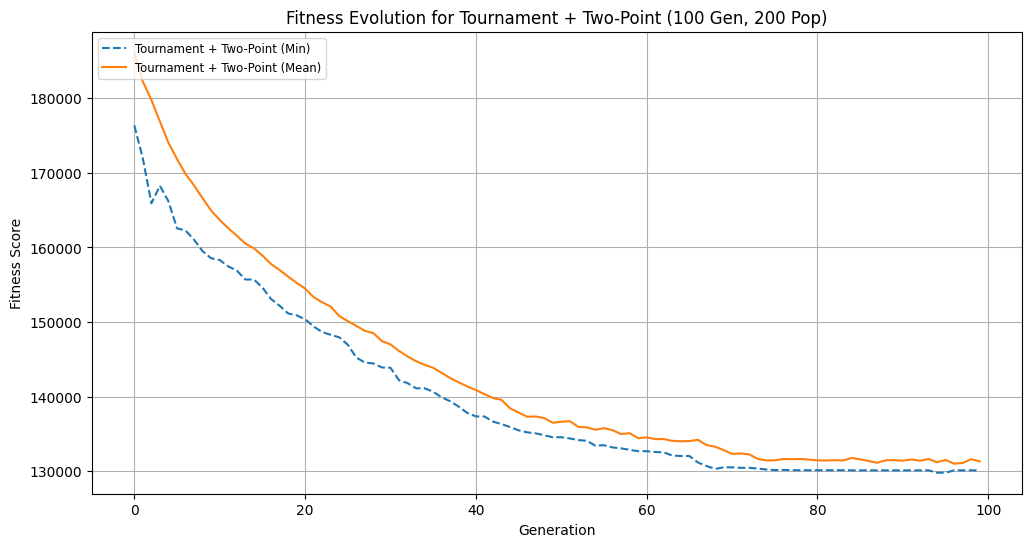

  Running strategy: Roulette + Blend


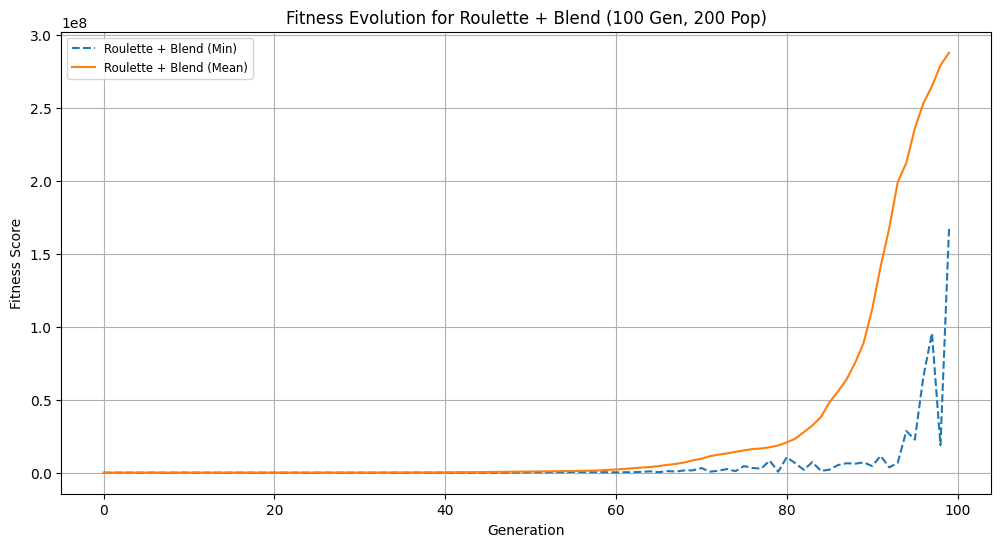

  Running strategy: Rank-Based + Uniform


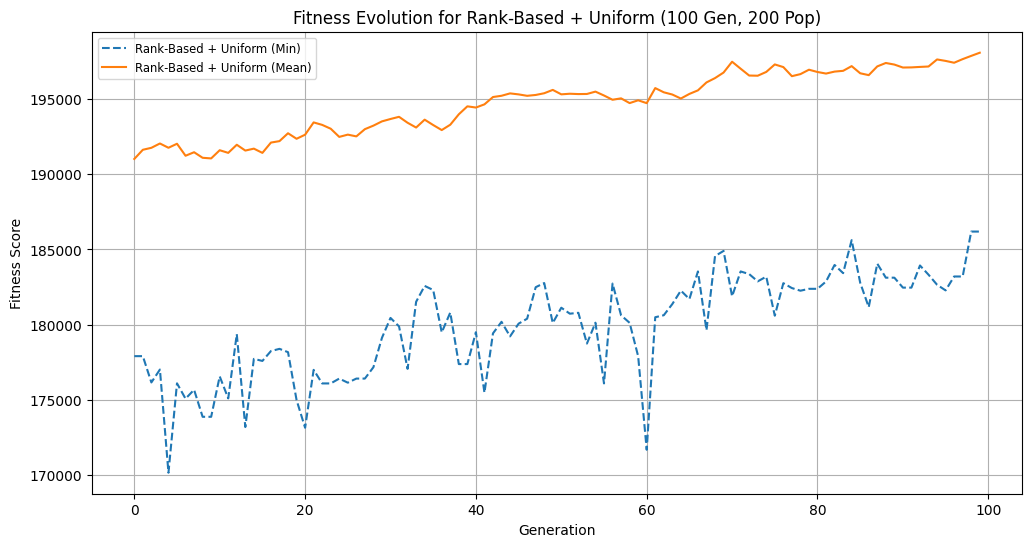

  Running strategy: Tournament + Multi-Point


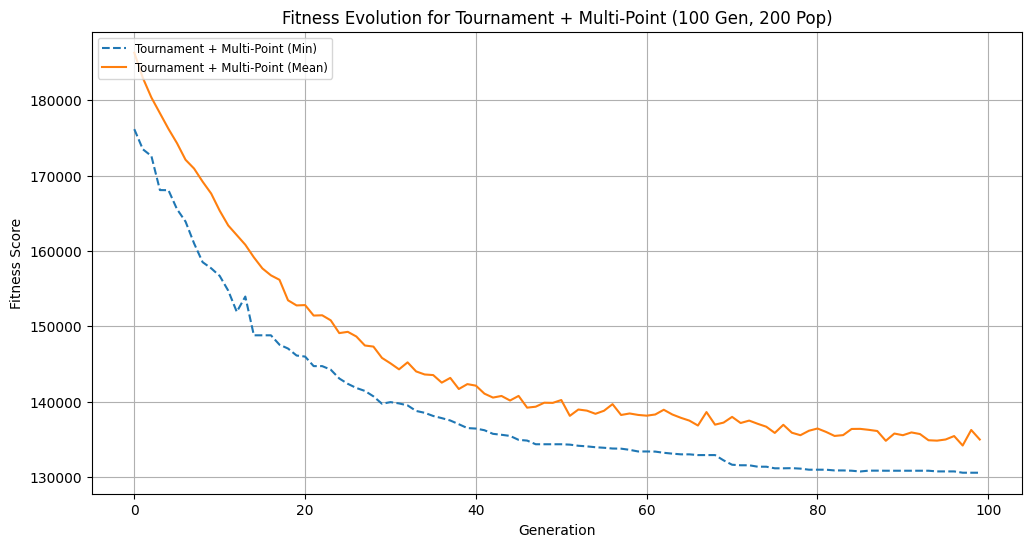

  Running strategy: Roulette + One-Point


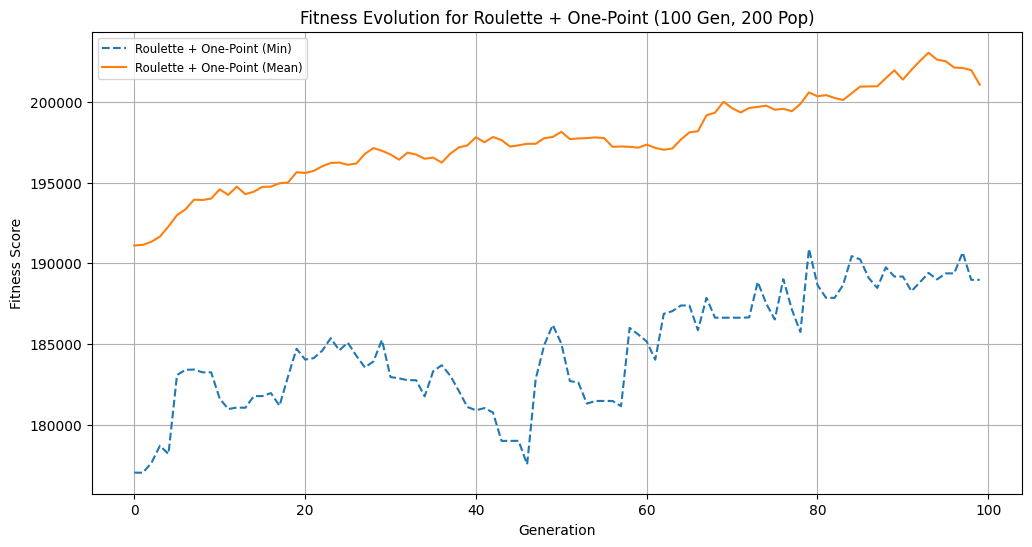


Running GA for 100 Generations and Population Size 300
  Running strategy: Tournament + Two-Point


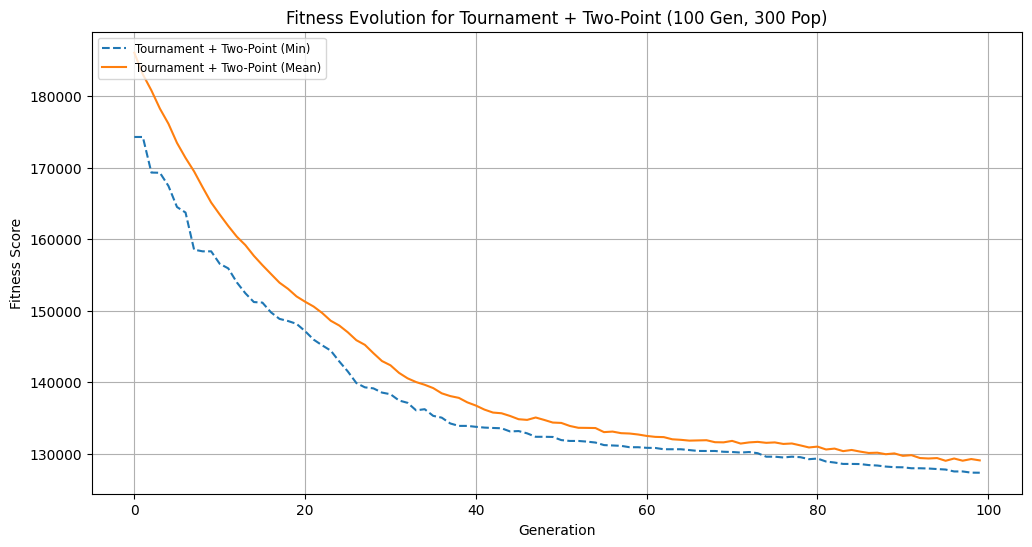

  Running strategy: Roulette + Blend


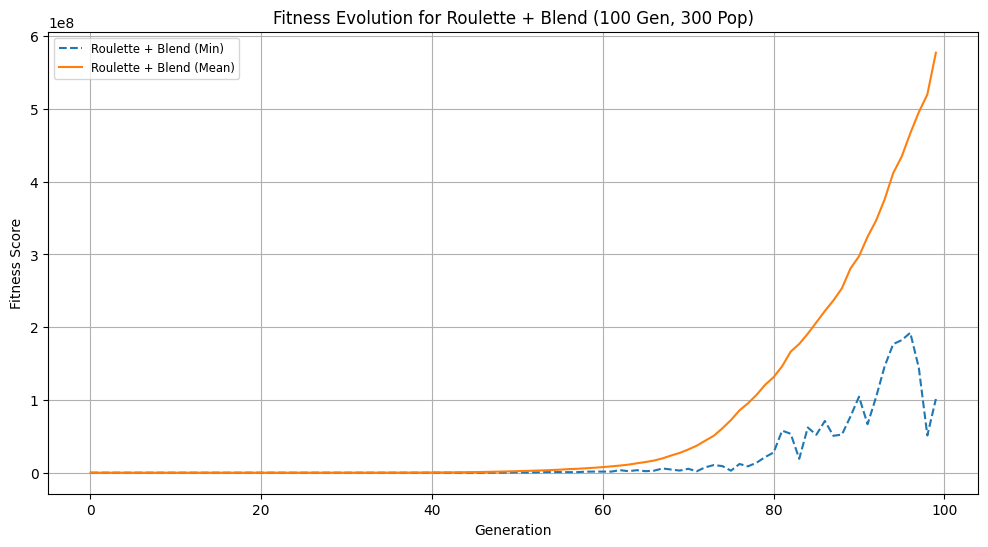

  Running strategy: Rank-Based + Uniform


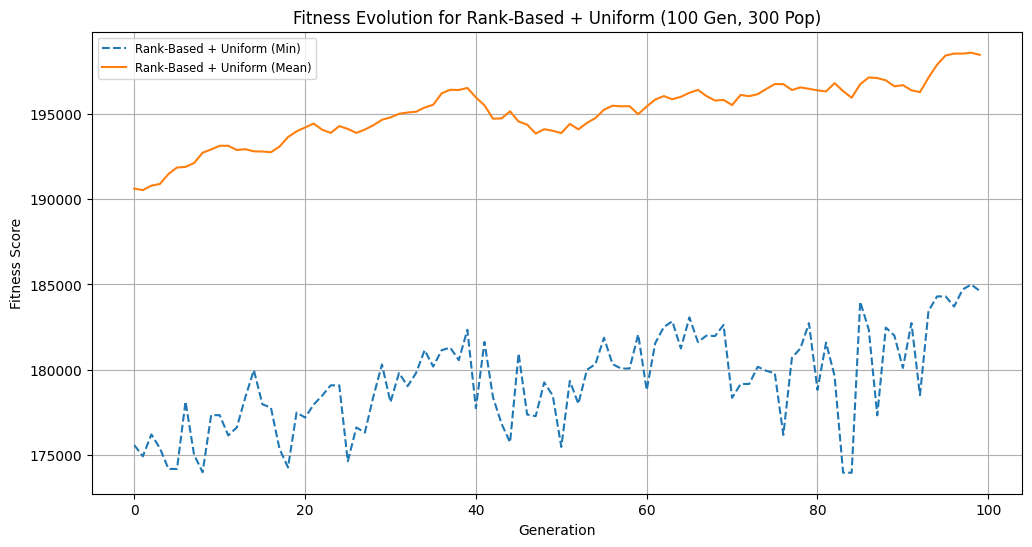

  Running strategy: Tournament + Multi-Point


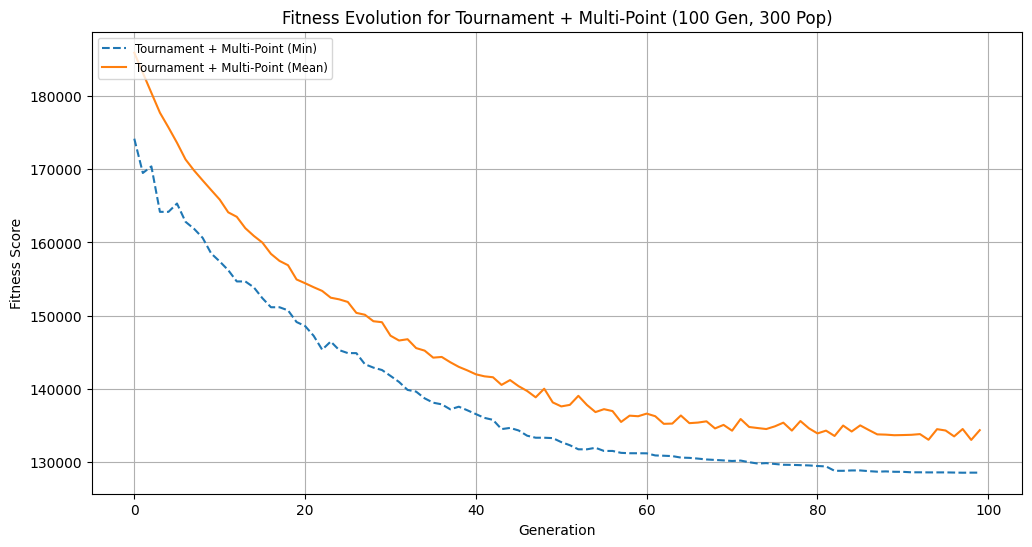

  Running strategy: Roulette + One-Point


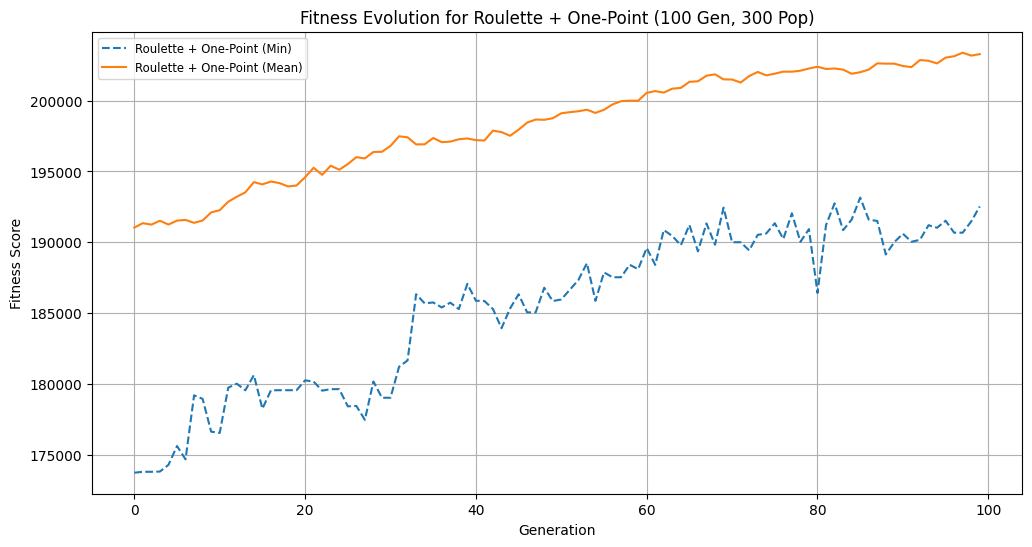


Running GA for 150 Generations and Population Size 50
  Running strategy: Tournament + Two-Point


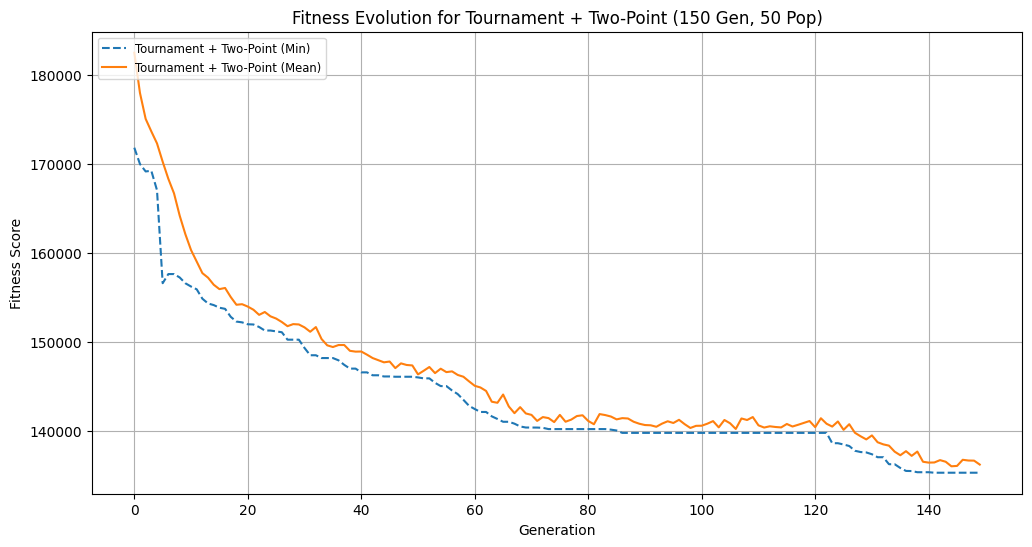

  Running strategy: Roulette + Blend


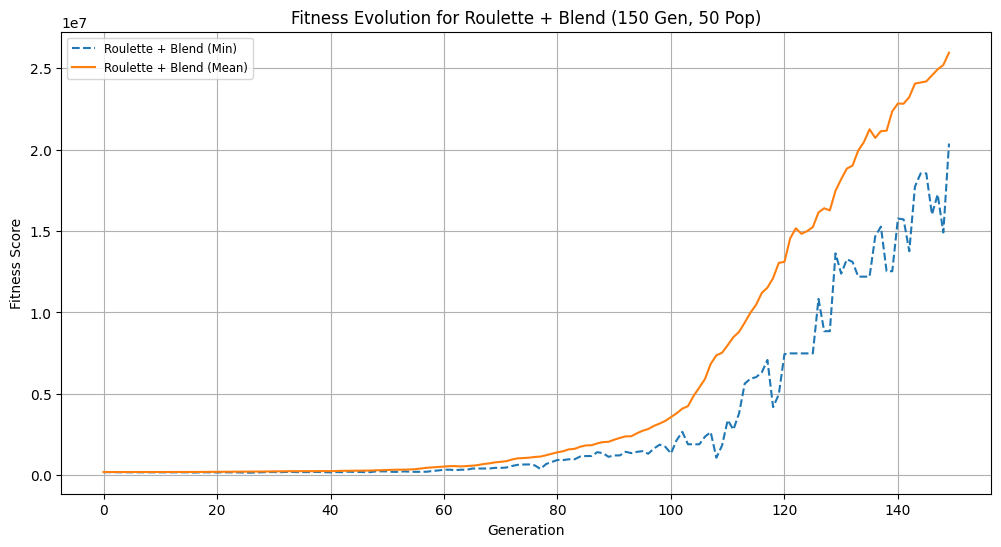

  Running strategy: Rank-Based + Uniform


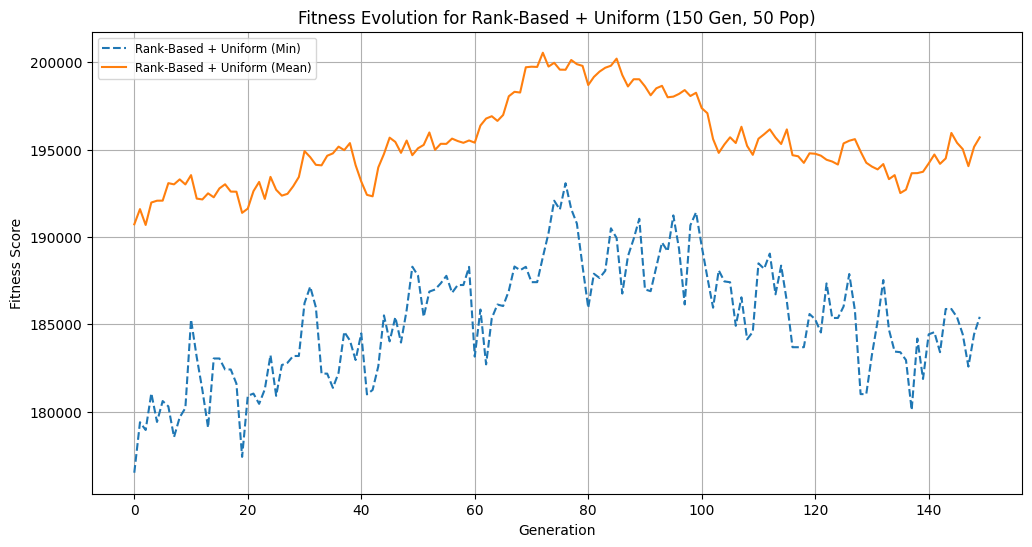

  Running strategy: Tournament + Multi-Point


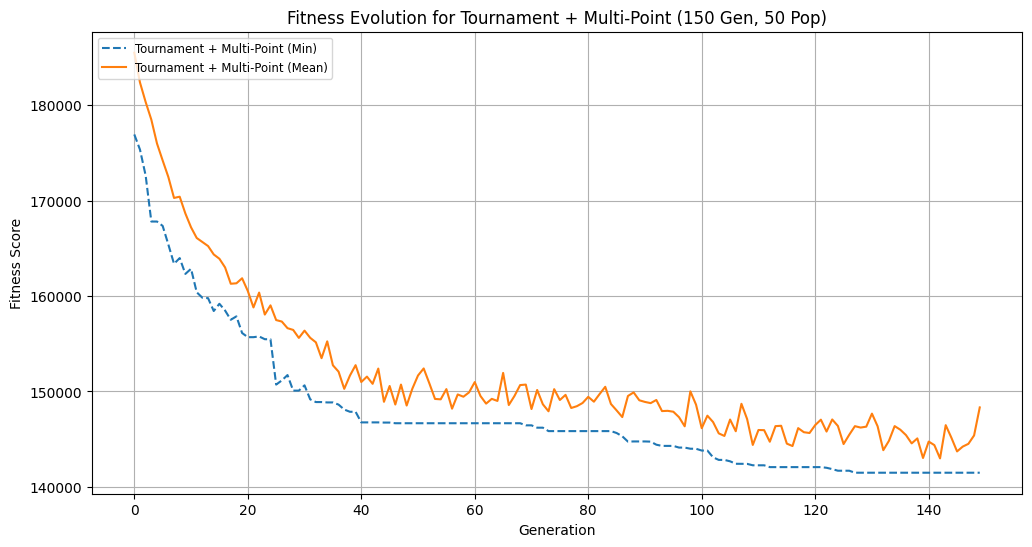

  Running strategy: Roulette + One-Point


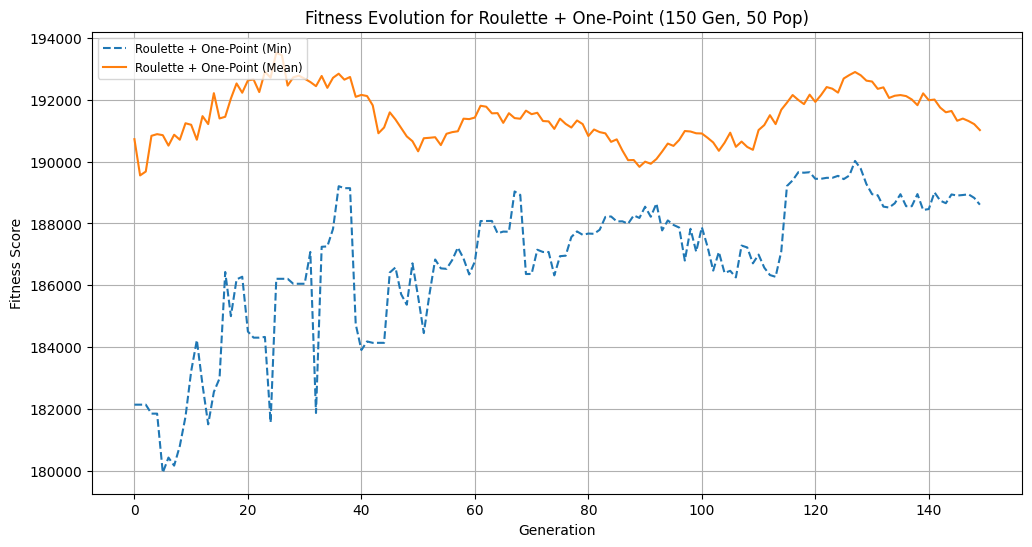


Running GA for 150 Generations and Population Size 100
  Running strategy: Tournament + Two-Point


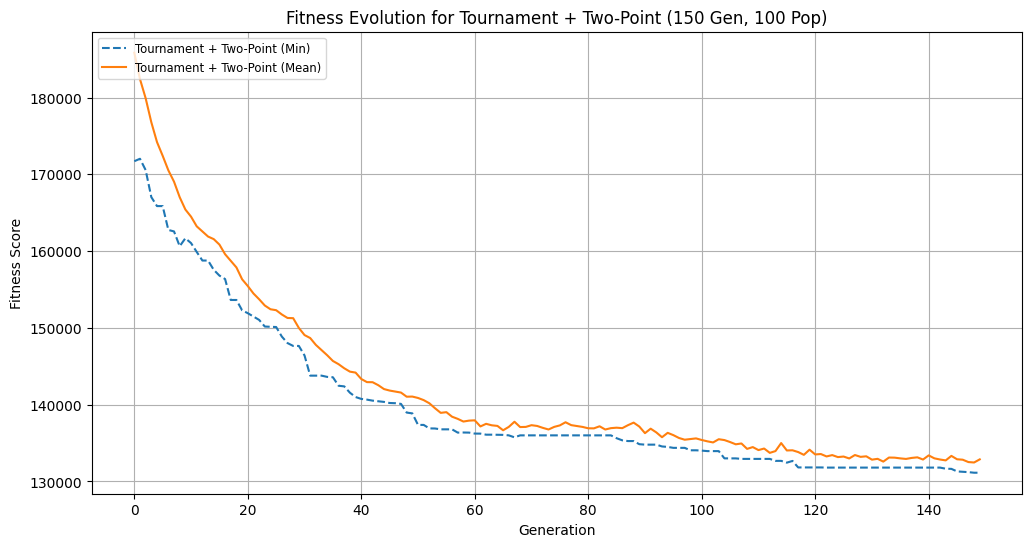

  Running strategy: Roulette + Blend


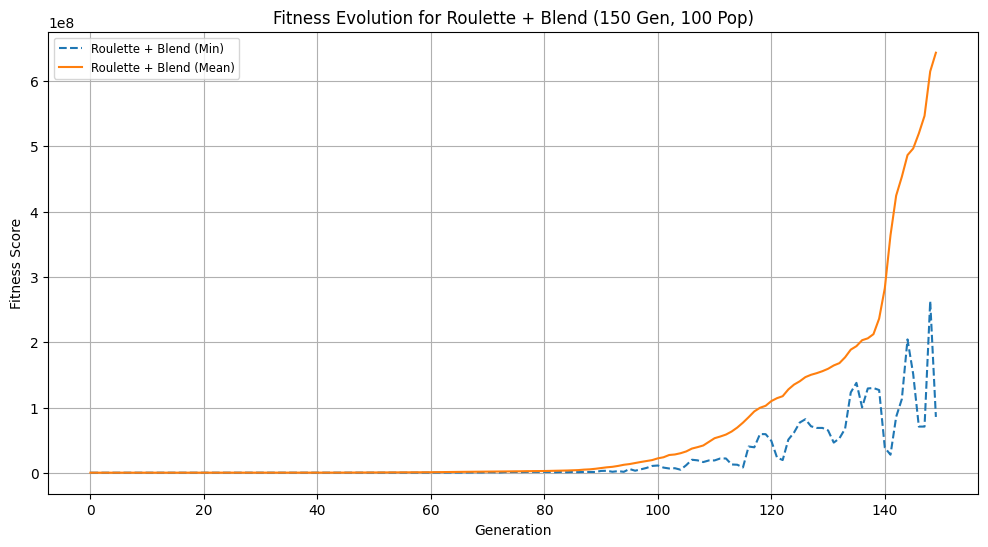

  Running strategy: Rank-Based + Uniform


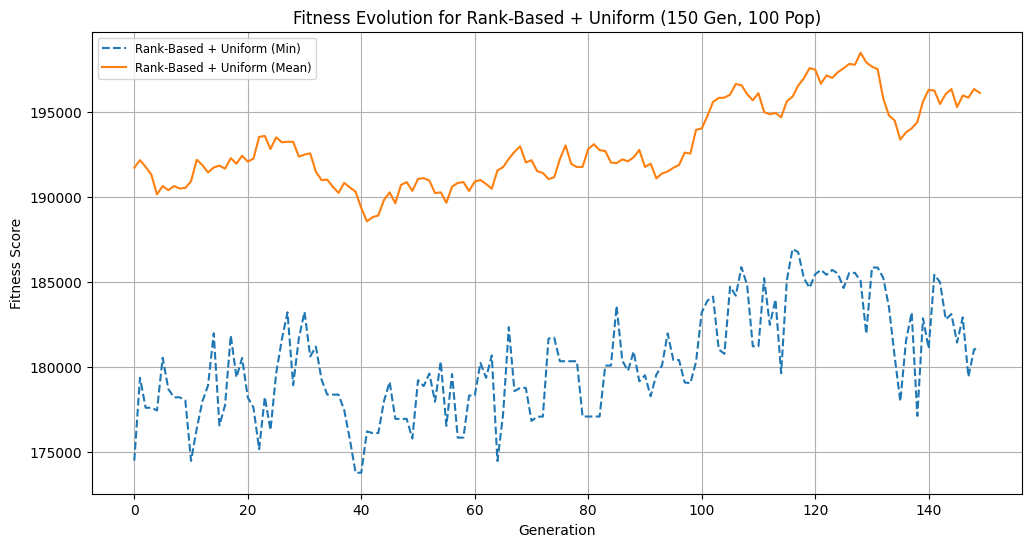

  Running strategy: Tournament + Multi-Point


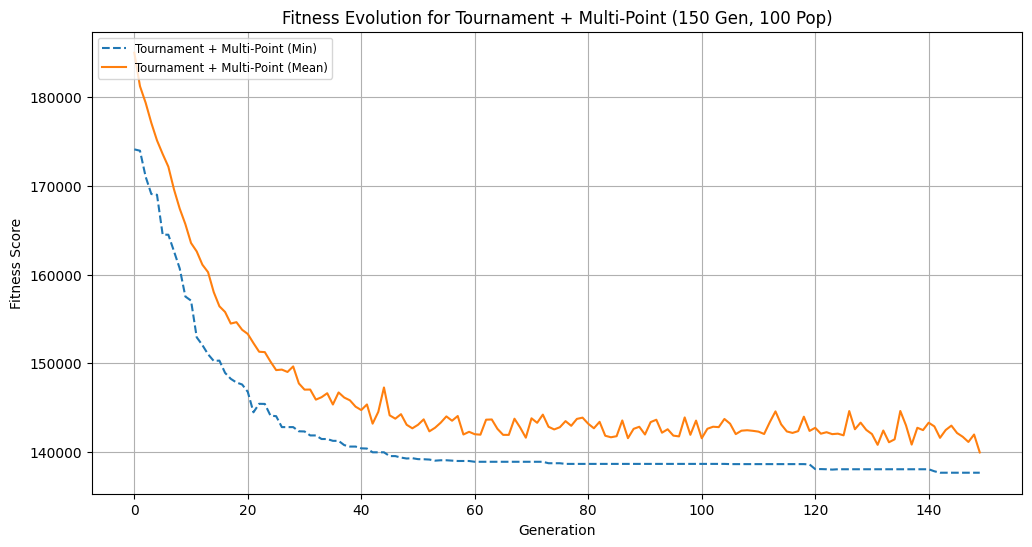

  Running strategy: Roulette + One-Point


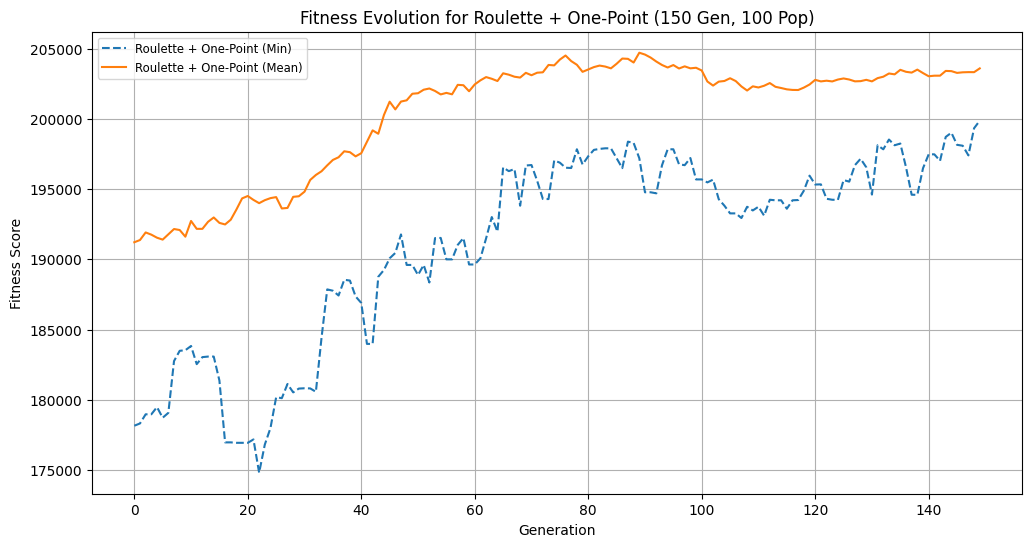


Running GA for 150 Generations and Population Size 200
  Running strategy: Tournament + Two-Point


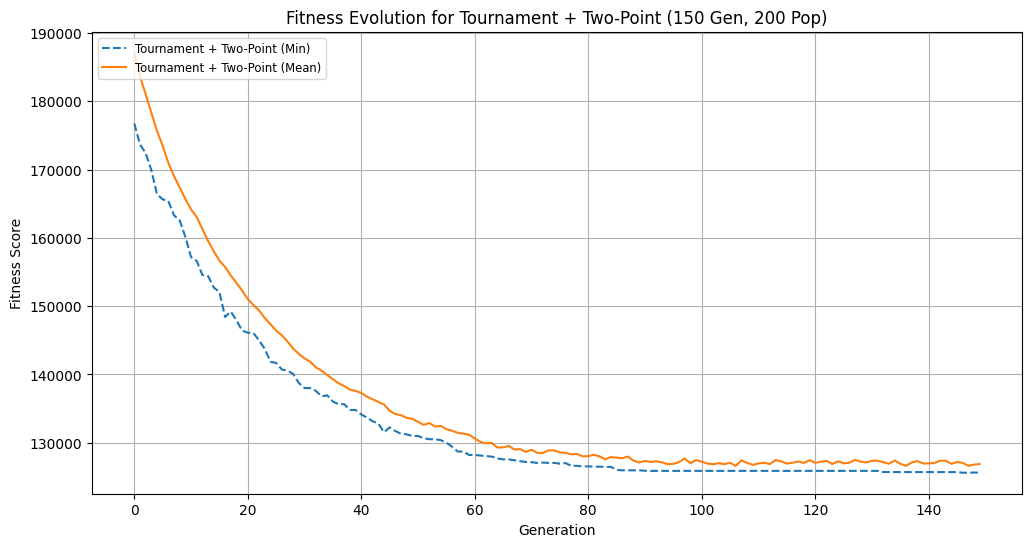

  Running strategy: Roulette + Blend


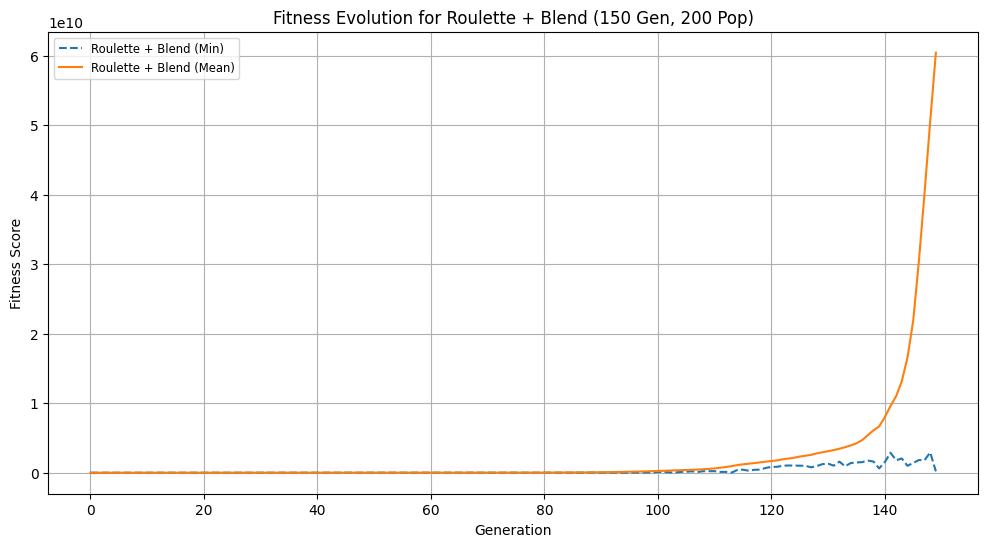

  Running strategy: Rank-Based + Uniform


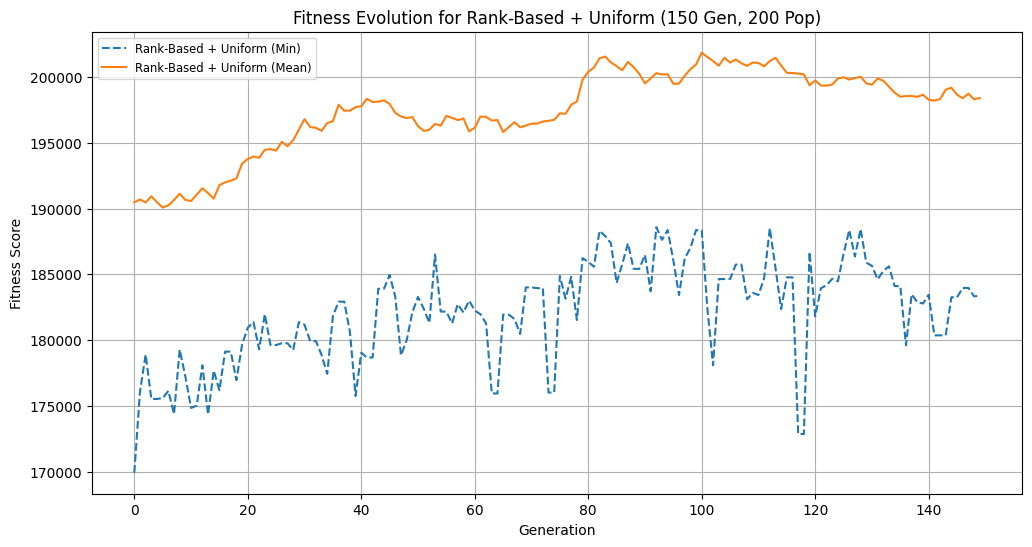

  Running strategy: Tournament + Multi-Point


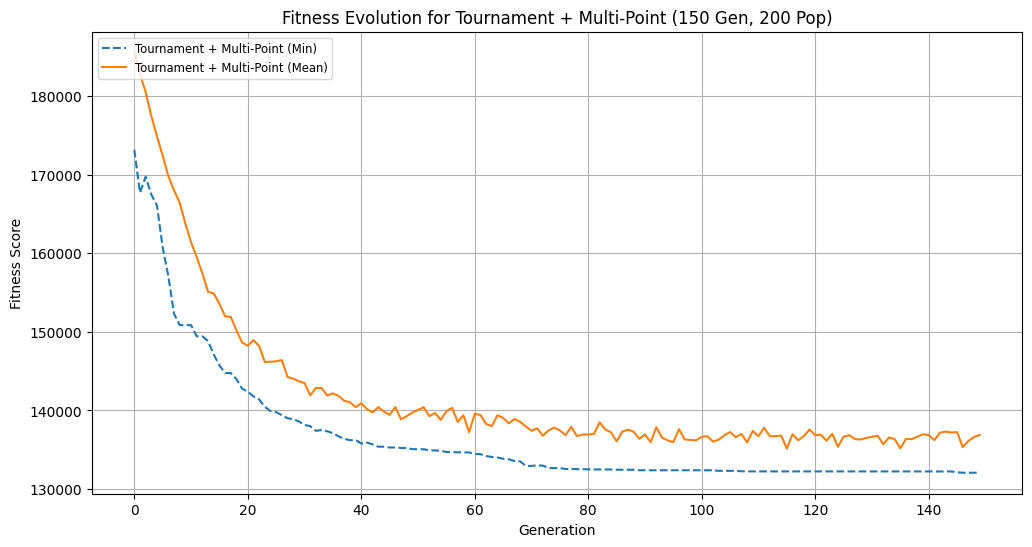

  Running strategy: Roulette + One-Point


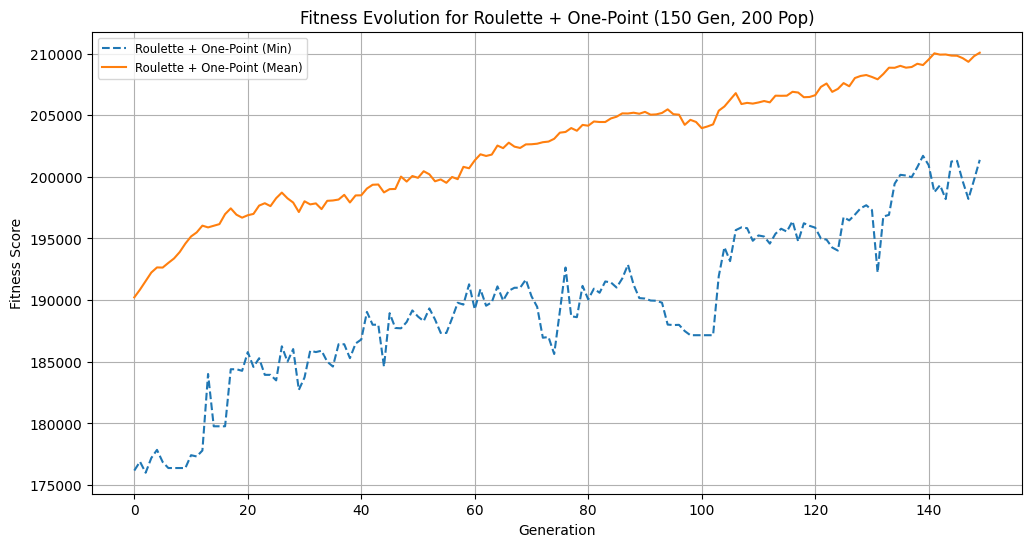


Running GA for 150 Generations and Population Size 300
  Running strategy: Tournament + Two-Point


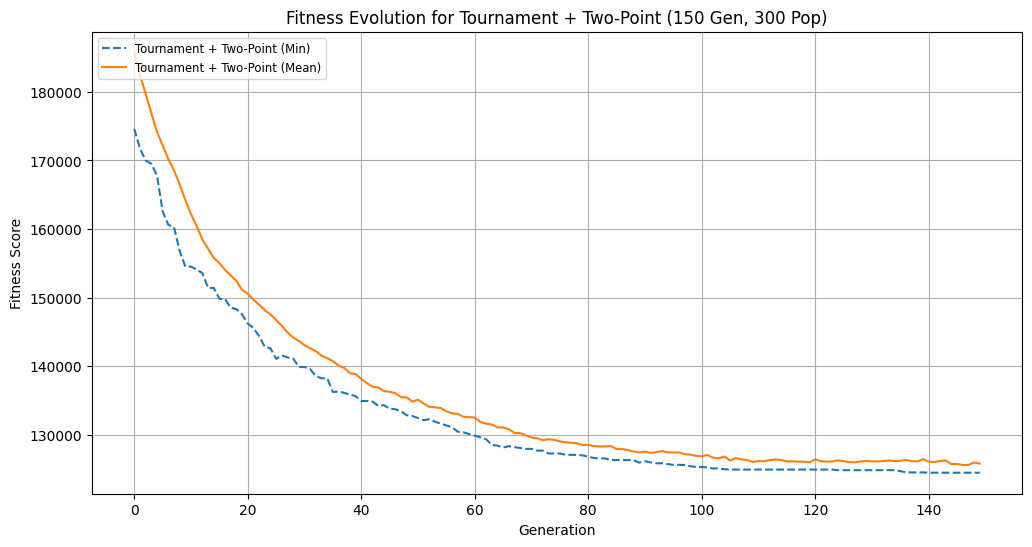

  Running strategy: Roulette + Blend


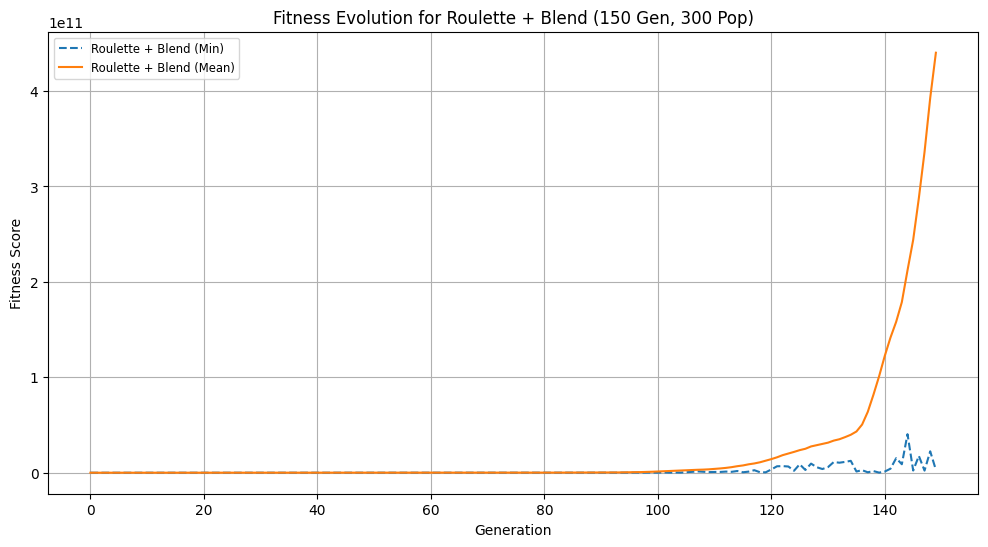

  Running strategy: Rank-Based + Uniform


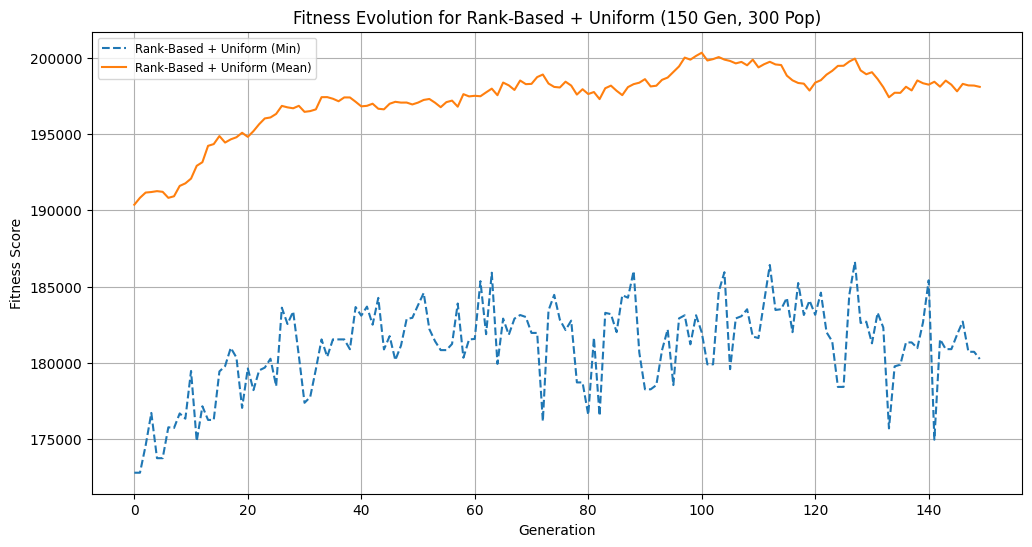

  Running strategy: Tournament + Multi-Point


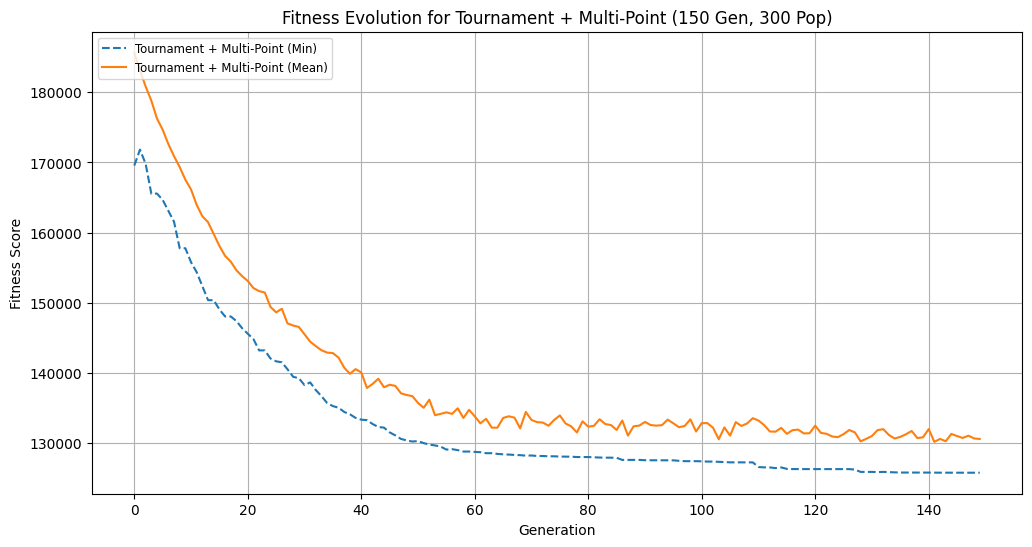

  Running strategy: Roulette + One-Point


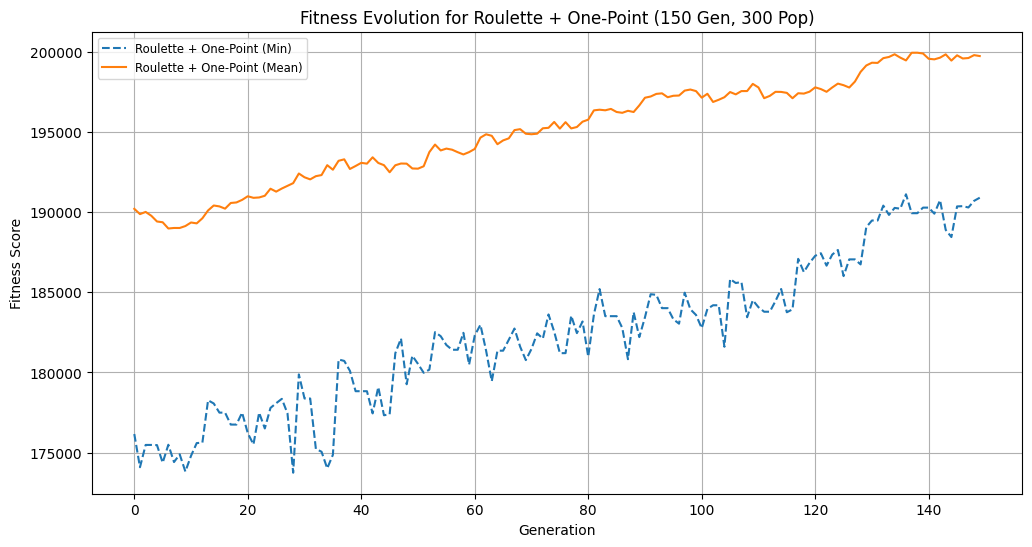


All tests completed. Results saved to: /content/drive/My Drive/CI/CW/Best_strategy_results.csv


In [8]:
# --- Custom Multi-Point Crossover ---
def cxMultiPoint(ind1, ind2, num_points=3):
    size = min(len(ind1), len(ind2))
    cx_points = sorted(np.random.choice(range(1, size), num_points, replace=False))
    toggle = False
    for i in range(size):
        if i in cx_points:
            toggle = not toggle
        if toggle:
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

# --- Custom Weighted Roulette Selection ---
def selWeightedRoulette(individuals, k, weights=None):
    if weights is None:
        weights = [ind.fitness.values[0] for ind in individuals]
    total = sum(weights)
    probabilities = [w / total for w in weights]
    indices = np.random.choice(len(individuals), size=k, replace=True, p=probabilities)
    return [individuals[i] for i in indices]

# --- Custom Swap Mutation ---
def mutSwap(individual, indpb=0.2):
    for i in range(len(individual)):
        if np.random.random() < indpb:
            swap_idx = np.random.randint(0, len(individual))
            individual[i], individual[swap_idx] = individual[swap_idx], individual[i]
    return individual,

# --- Step 1: Define the Fitness Function ---
def calculate_fitness(individual):
    transport_cost = 0
    holding_cost = 0
    stockout_penalty = 0

    allocation = np.reshape(individual, (num_products, num_warehouses))
    demand_met = np.sum(allocation, axis=1)
    warehouse_stock = warehouse_df["Current_Stock"].values - np.sum(allocation, axis=0)

    # Transport Cost
    for i, product_allocation in enumerate(allocation):
        for j, allocation_to_warehouse in enumerate(product_allocation):
            transport_cost += allocation_to_warehouse * transport_df["Cost_Per_Unit"].mean()

    # Holding Cost
    for i, stock in enumerate(warehouse_stock):
        if stock >= 0:
            holding_cost += stock * warehouse_df.loc[i, "Holding_Cost"]

    # Stockout Penalty
    for i, row in forecasted_demand_df.iterrows():
        product_id = int(row["Product"]) - 1
        forecasted_demand = row["Forecasted_Demand"]
        if forecasted_demand > demand_met[product_id]:
            stockout_penalty += (forecasted_demand - demand_met[product_id]) * 10

    return (transport_cost + holding_cost + stockout_penalty) / 100,

# --- Step 2: Configure GA for Multiple Strategies ---
strategies = {
    "Tournament + Two-Point": {"select": tools.selTournament, "mate": tools.cxTwoPoint, "mutate": tools.mutUniformInt},
    "Roulette + Blend": {"select": tools.selRoulette, "mate": tools.cxBlend, "mutate": tools.mutGaussian},
    "Rank-Based + Uniform": {"select": selWeightedRoulette, "mate": tools.cxUniform, "mutate": tools.mutUniformInt},
    "Tournament + Multi-Point": {"select": tools.selTournament, "mate": cxMultiPoint, "mutate": mutSwap},
    "Roulette + One-Point": {"select": tools.selRoulette, "mate": tools.cxOnePoint, "mutate": tools.mutGaussian},
}

# --- Step 3: Range of Generations and Population Sizes ---
generations_range = [50, 100, 150]  # Different numbers of generations to test
populations_range = [50, 100, 200, 300]  # Different population sizes to test


# Run GA for all combinations of Generations and Populations
for num_generations in generations_range:
    for population_size in populations_range:
        print(f"\nRunning GA for {num_generations} Generations and Population Size {population_size}")

        # Run Genetic Algorithm for each strategy
        for strategy_name, operators in strategies.items():
            print(f"  Running strategy: {strategy_name}")

            try:
                creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
                creator.create("Individual", list, fitness=creator.FitnessMin)
            except AttributeError:
                pass

            toolbox = base.Toolbox()
            toolbox.register("attr_int", np.random.randint, 0, 100)
            toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=num_products * num_warehouses)
            toolbox.register("population", tools.initRepeat, list, toolbox.individual)
            toolbox.register("evaluate", calculate_fitness)

            if operators["select"] == tools.selTournament:
                toolbox.register("select", operators["select"], tournsize=3)
            elif operators["select"] == tools.selRoulette:
                toolbox.register("select", selWeightedRoulette, weights=None)
            else:
                toolbox.register("select", operators["select"])

            if "Blend" in strategy_name:
                toolbox.register("mate", operators["mate"], alpha=0.5)
            elif operators["mate"] == tools.cxUniform:
                toolbox.register("mate", tools.cxUniform, indpb=0.5)
            else:
                toolbox.register("mate", operators["mate"])

            if operators["mutate"] == tools.mutGaussian:
                toolbox.register("mutate", operators["mutate"], mu=0, sigma=1.0, indpb=0.2)
            elif operators["mutate"] == tools.mutUniformInt:
                toolbox.register("mutate", operators["mutate"], low=0, up=100, indpb=0.1)
            else:
                toolbox.register("mutate", operators["mutate"])

            logbook = tools.Logbook()
            logbook.header = ["gen", "min", "mean"]

            # Initialize population
            population = toolbox.population(n=population_size)

            for gen in range(num_generations):
                algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=1, verbose=False)
                fits = [ind.fitness.values[0] for ind in population]
                min_fit = np.min(fits)
                mean_fit = np.mean(fits)
                logbook.record(gen=gen, min=min_fit, mean=mean_fit)

            # Log results for this strategy
            best_individual = tools.selBest(population, k=1)[0]
            best_fitness = best_individual.fitness.values[0]

            # Save results to CSV
            with open(drive_csv_path, mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([strategy_name, best_fitness, num_generations, population_size])

            # Visualize Fitness Evolution for Each Strategy
            plt.figure(figsize=(12, 6))
            generations = [record["gen"] for record in logbook]
            min_fitness = [record["min"] for record in logbook]
            mean_fitness = [record["mean"] for record in logbook]

            plt.plot(generations, min_fitness, label=f"{strategy_name} (Min)", linestyle='--')
            plt.plot(generations, mean_fitness, label=f"{strategy_name} (Mean)")

            plt.title(f"Fitness Evolution for {strategy_name} ({num_generations} Gen, {population_size} Pop)")
            plt.xlabel("Generation")
            plt.ylabel("Fitness Score")
            plt.legend(loc="upper left", fontsize="small")
            plt.grid(True)

            # Save the plot
            plt.savefig(f"/content/drive/MyDrive/CI/CW/FitnessEvolution/{strategy_name.replace(' ', '_')}_fitness_{num_generations}_{population_size}.png")
            plt.show()

print(f"\nAll tests completed. Results saved to: {drive_csv_path}")


In [11]:
data = pd.read_csv("/content/drive/MyDrive/CI/CW/Best_strategy_results.csv")
# Create a DataFrame
results_df = pd.DataFrame(data)
print(results_df.columns)

Index(['Strategy Name', 'Best Fitness Value', 'Generations', 'Population'], dtype='object')


In [33]:
# Calculate minimum best fitness values by strategy
min_fitness_by_strategy = results_df.groupby("Strategy Name")["Best Fitness Value"].min().reset_index()

# Rename the column for clarity
min_fitness_by_strategy.rename(columns={"Best Fitness Value": "Minimum Best Fitness Value"}, inplace=True)

# Create a column for fitness values in thousands
min_fitness_by_strategy["Minimum Best Fitness Value (in Thousands)"] = min_fitness_by_strategy["Minimum Best Fitness Value"] / 1000

# Sort the DataFrame by Minimum Best Fitness Value in ascending order
min_fitness_by_strategy = min_fitness_by_strategy.sort_values(by="Minimum Best Fitness Value", ascending=True)

# Display the sorted DataFrame
print(min_fitness_by_strategy)



              Strategy Name  Minimum Best Fitness Value  Minimum Best Fitness Value (in Thousands)
4    Tournament + Two-Point               124500.272213                                 124.500272
3  Tournament + Multi-Point               125737.943595                                 125.737944
1          Roulette + Blend               163189.787853                                 163.189788
2      Roulette + One-Point               175668.214410                                 175.668214
0      Rank-Based + Uniform               178492.842883                                 178.492843


              Strategy Name  Minimum Best Fitness Value  Minimum Best Fitness Value (in Thousands)
4    Tournament + Two-Point               124500.272213                                 124.500272
3  Tournament + Multi-Point               125737.943595                                 125.737944
1          Roulette + Blend               163189.787853                                 163.189788
2      Roulette + One-Point               175668.214410                                 175.668214
0      Rank-Based + Uniform               178492.842883                                 178.492843


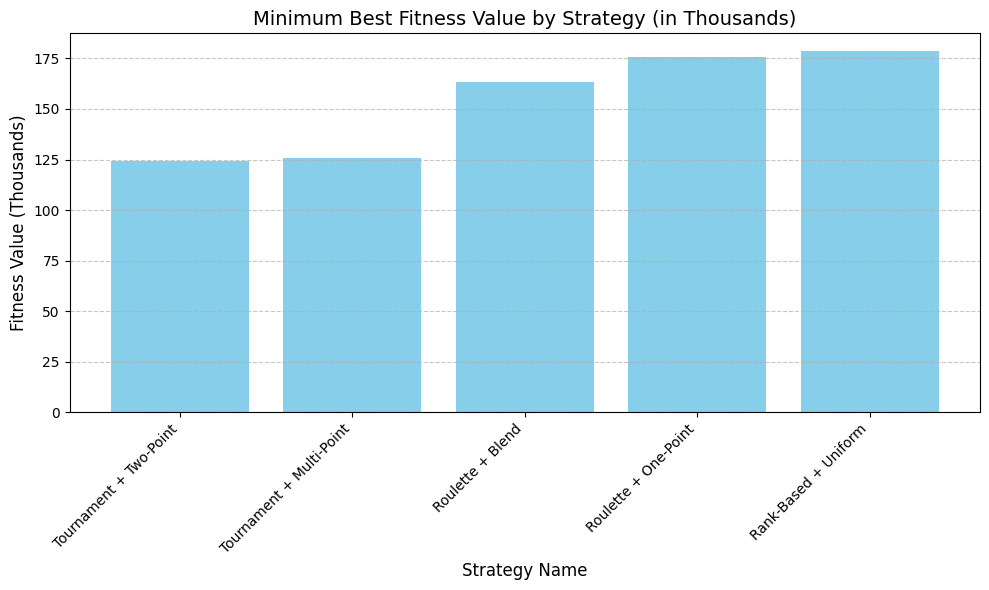

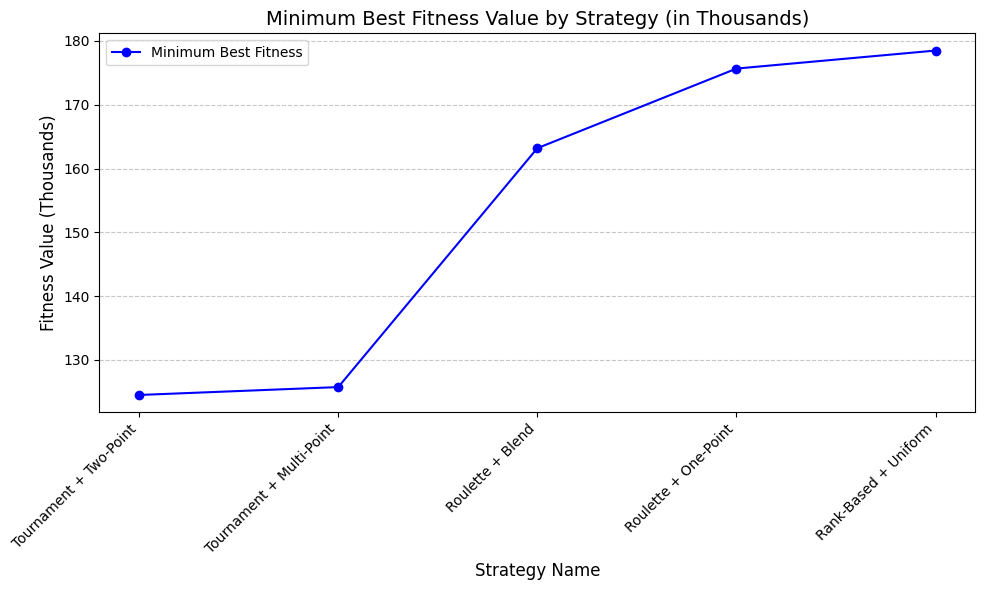

In [20]:

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(
    min_fitness_by_strategy["Strategy Name"],
    min_fitness_by_strategy["Minimum Best Fitness Value (in Thousands)"],
    color='skyblue'
)

# Customize the bar chart
plt.title("Minimum Best Fitness Value by Strategy (in Thousands)", fontsize=14)
plt.xlabel("Strategy Name", fontsize=12)
plt.ylabel("Fitness Value (Thousands)", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the bar chart
plt.tight_layout()
plt.show()

# Plot a line graph
plt.figure(figsize=(10, 6))
plt.plot(
    min_fitness_by_strategy["Strategy Name"],
    min_fitness_by_strategy["Minimum Best Fitness Value (in Thousands)"],
    marker='o', linestyle='-', color='b', label="Minimum Best Fitness"
)

# Customize the line graph
plt.title("Minimum Best Fitness Value by Strategy (in Thousands)", fontsize=14)
plt.xlabel("Strategy Name", fontsize=12)
plt.ylabel("Fitness Value (Thousands)", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the line graph
plt.tight_layout()
plt.show()



In [32]:
# --- Extract the Best Solution from GA Population ---
def find_best_solution(population, results_df):
    # Step 1: Select the individual with the minimum fitness from the population
    best_individual = tools.selBest(population, k=1)[0]  # Ensures the individual with the minimum fitness is selected
    best_fitness = best_individual.fitness.values[0]

    # Step 2: Debug to ensure the fitness matches
    print(f"Best Fitness from GA Population: {best_fitness}")
    print("Top 5 Fitness Values from DataFrame:")
    print(results_df.nsmallest(5, "Best Fitness Value"))

    # Step 3: Match the fitness value with the DataFrame
    min_fitness_row = results_df[results_df["Best Fitness Value"] == best_fitness].iloc[0]
    strategy_name = min_fitness_row["Strategy Name"]
    num_generations = min_fitness_row["Generations"]
    population_size = min_fitness_row["Population"]

    # Step 4: Reshape the individual into a readable format
    best_allocation = np.reshape(best_individual, (num_products, num_warehouses))

    return best_individual, best_fitness, best_allocation, strategy_name, num_generations, population_size

# Example Usage After GA Execution
best_individual, best_fitness, best_allocation, strategy_name, num_generations, population_size = find_best_solution(population, results_df)

# Display Results
print(f"Strategy: {strategy_name}")
print(f"Generations: {num_generations}")
print(f"Population Size: {population_size}")
print(f"Best Fitness Value (Total Cost): {best_fitness}")
print("Best Allocation Matrix:")
print(best_allocation)


Best Fitness from GA Population: 190906.46690694385
Top 5 Fitness Values from DataFrame:
               Strategy Name  Best Fitness Value  Generations  Population
55    Tournament + Two-Point       124500.272213          150         300
50    Tournament + Two-Point       125632.201839          150         200
58  Tournament + Multi-Point       125737.943595          150         300
35    Tournament + Two-Point       127335.886969          100         300
38  Tournament + Multi-Point       128543.546470          100         300
Strategy: Roulette + One-Point
Generations: 150
Population Size: 300
Best Fitness Value (Total Cost): 190906.46690694385
Best Allocation Matrix:
[[ 99.30764739  82.23801407   5.28042457]
 [ 94.6697475   16.19882133  93.57519288]
 [ 25.90414411  59.57529662  96.97917856]
 [ 18.46886283  77.60051765  10.3576916 ]
 [ 64.17701325  57.32664924  62.67678139]
 [ 53.39293404  16.63137179  78.28500408]
 [  5.06971619   8.74746654  36.97251328]
 [ 36.1727561   46.88085279 

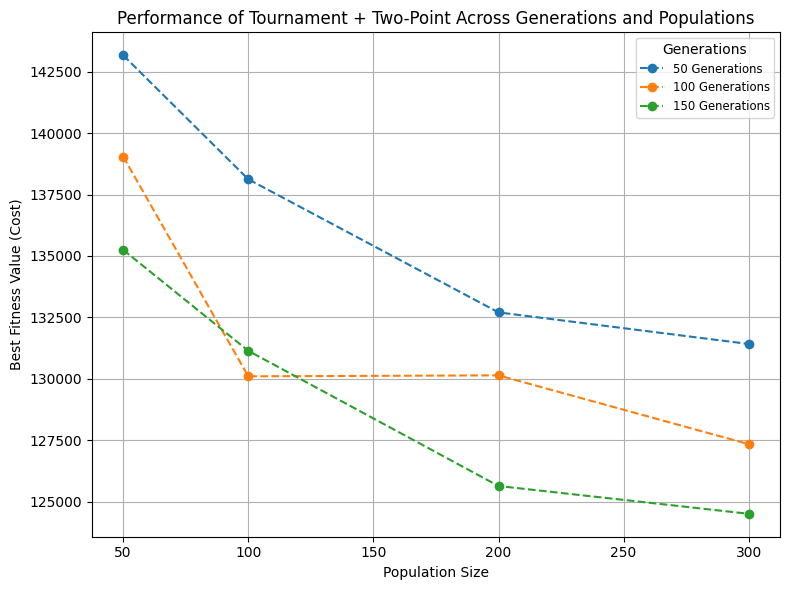

Saved plot: Tournament_+_Two-Point_performance_generations.png


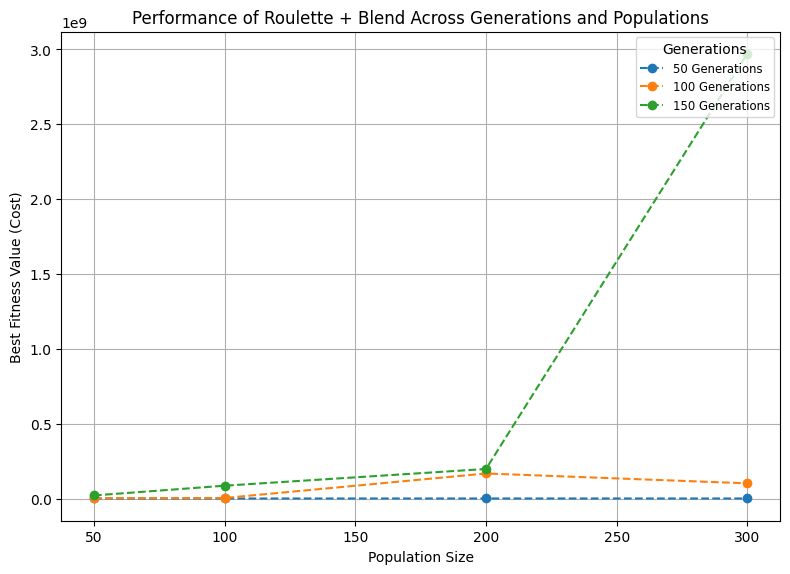

Saved plot: Roulette_+_Blend_performance_generations.png


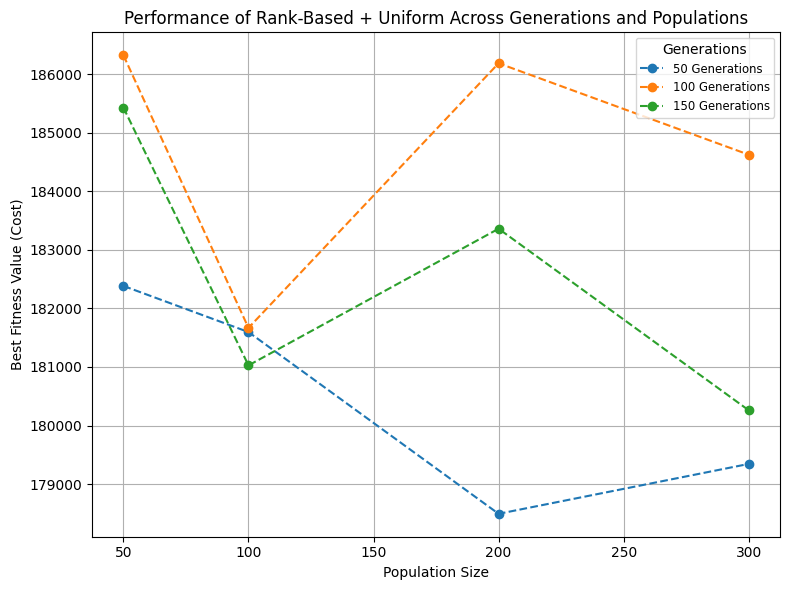

Saved plot: Rank-Based_+_Uniform_performance_generations.png


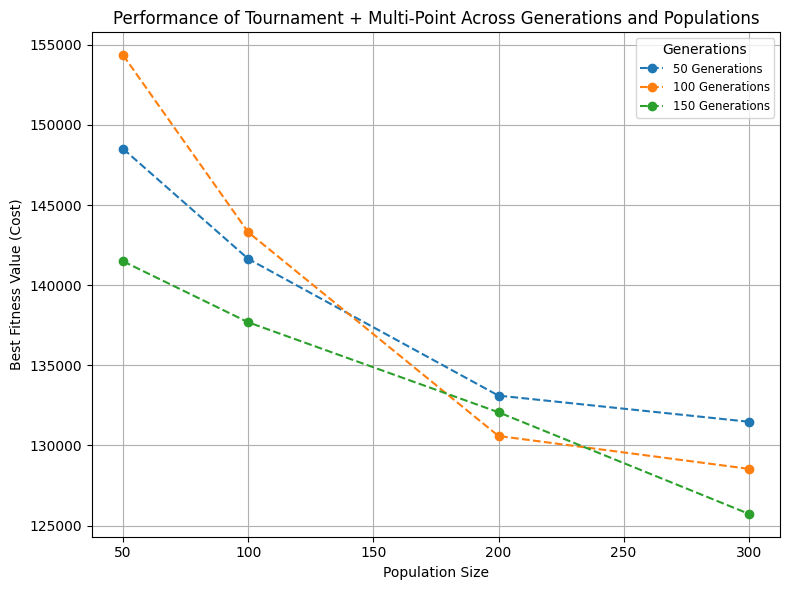

Saved plot: Tournament_+_Multi-Point_performance_generations.png


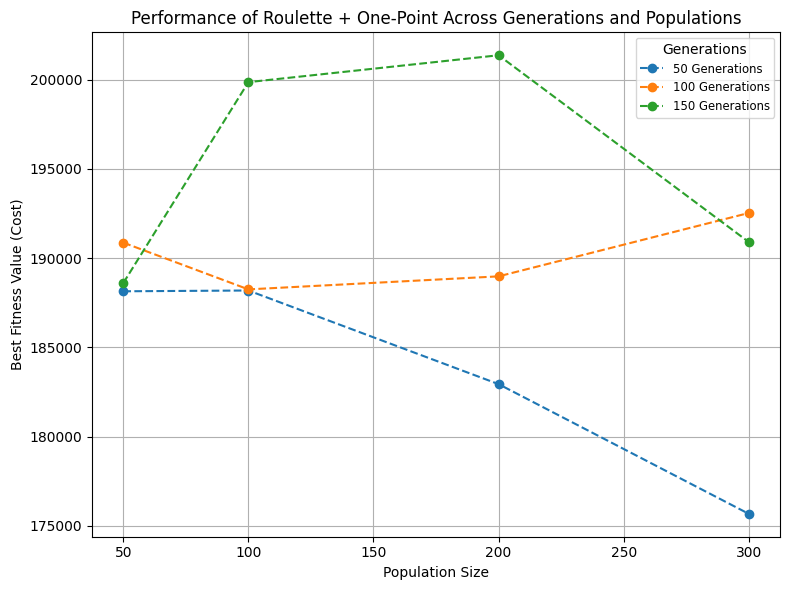

Saved plot: Roulette_+_One-Point_performance_generations.png


In [34]:
# --- Visualization: One Graph Per Strategy with Generations ---
def plot_strategy_results(strategy_results, strategy_name, generations_range):
    plt.figure(figsize=(8, 6))

    # Plot for each generation
    for gen in generations_range:
        gen_data = strategy_results[strategy_results['Generations'] == gen]
        plt.plot(
            gen_data['Population'],
            gen_data['Best Fitness Value'],
            marker='o', linestyle='--', label=f"{gen} Generations"
        )

    # Customize the graph
    plt.title(f"Performance of {strategy_name} Across Generations and Populations")
    plt.xlabel("Population Size")
    plt.ylabel("Best Fitness Value (Cost)")
    plt.legend(title="Generations", loc="upper right", fontsize="small")
    plt.grid(True)
    plt.tight_layout()

    # Save and display the graph
    plot_name = f"{strategy_name.replace(' ', '_')}_performance_generations.png"
    plt.savefig(f"/content/drive/MyDrive/CI/CW/Visualization/GA{plot_name}")
    plt.show()
    print(f"Saved plot: {plot_name}")

# After running GA, create plots for each strategy
for strategy_name in strategies.keys():
    strategy_results = results_df[results_df['Strategy Name'] == strategy_name]
    plot_strategy_results(strategy_results, strategy_name, generations_range)



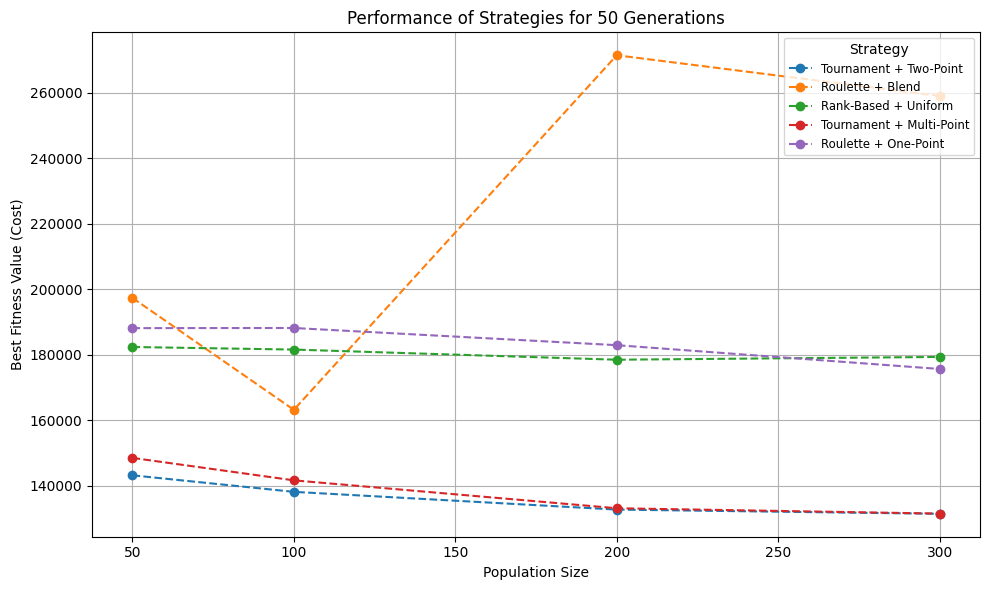

Saved plot: Generations_50_Strategies.png


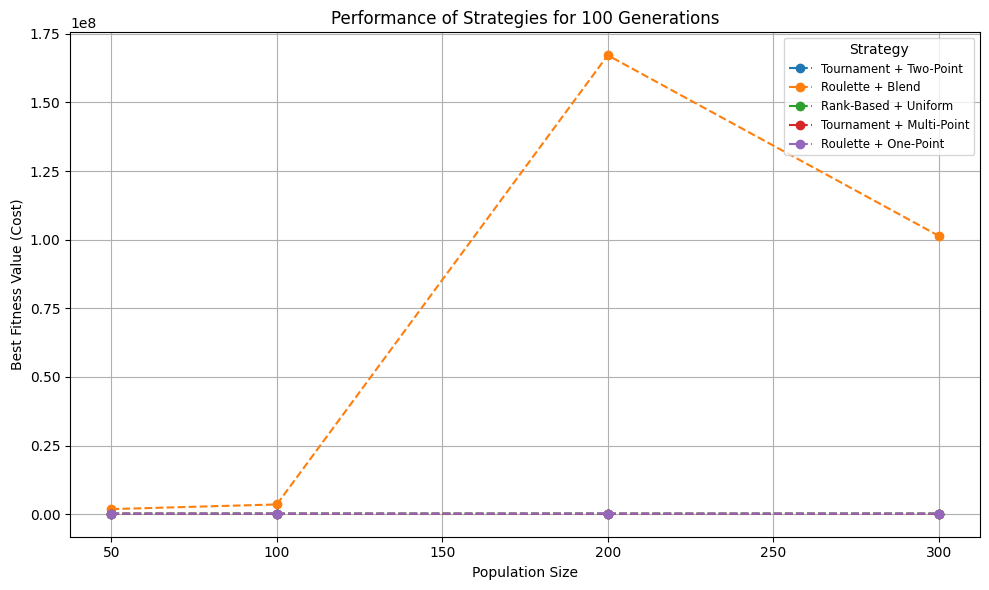

Saved plot: Generations_100_Strategies.png


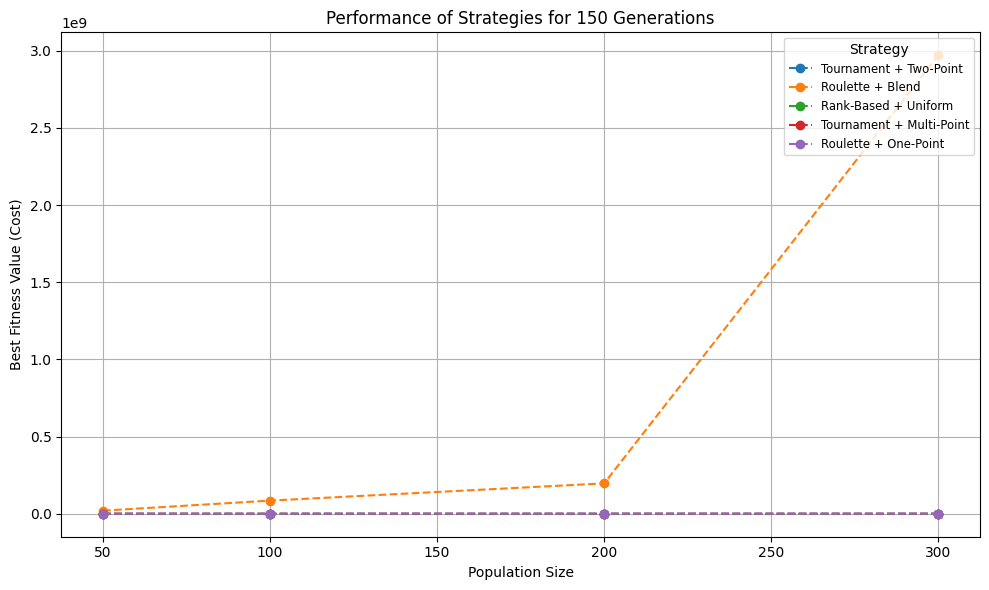

Saved plot: Generations_150_Strategies.png


In [35]:

# Plotting each generation with all strategies
for gen in generations_range:
    plt.figure(figsize=(10, 6))

    # Filter data for the current generation
    generation_data = results_df[results_df['Generations'] == gen]

    for strategy_name in strategies.keys():
        # Filter data for the current strategy
        strategy_data = generation_data[generation_data['Strategy Name'] == strategy_name]

        # Plot population vs best fitness value
        plt.plot(
            strategy_data['Population'],
            strategy_data['Best Fitness Value'],
            marker='o', linestyle='--',
            label=strategy_name
        )

    # Customize the plot
    plt.title(f"Performance of Strategies for {gen} Generations")
    plt.xlabel("Population Size")
    plt.ylabel("Best Fitness Value (Cost)")
    plt.legend(title="Strategy", loc="upper right", fontsize="small")
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plot_name = f"Generations_{gen}_Strategies.png"
    plt.savefig(f"/content/drive/MyDrive/CI/CW/Visualization/GA{plot_name}")
    plt.show()

    print(f"Saved plot: {plot_name}")


In [36]:
# Identify the best combinations
best_combinations = results_df.sort_values(by="Best Fitness Value").head(5)

# Display the best combinations
print("Top 5 Best Combinations:")
print(best_combinations)


Top 5 Best Combinations:
               Strategy Name  Best Fitness Value  Generations  Population
55    Tournament + Two-Point       124500.272213          150         300
50    Tournament + Two-Point       125632.201839          150         200
58  Tournament + Multi-Point       125737.943595          150         300
35    Tournament + Two-Point       127335.886969          100         300
38  Tournament + Multi-Point       128543.546470          100         300


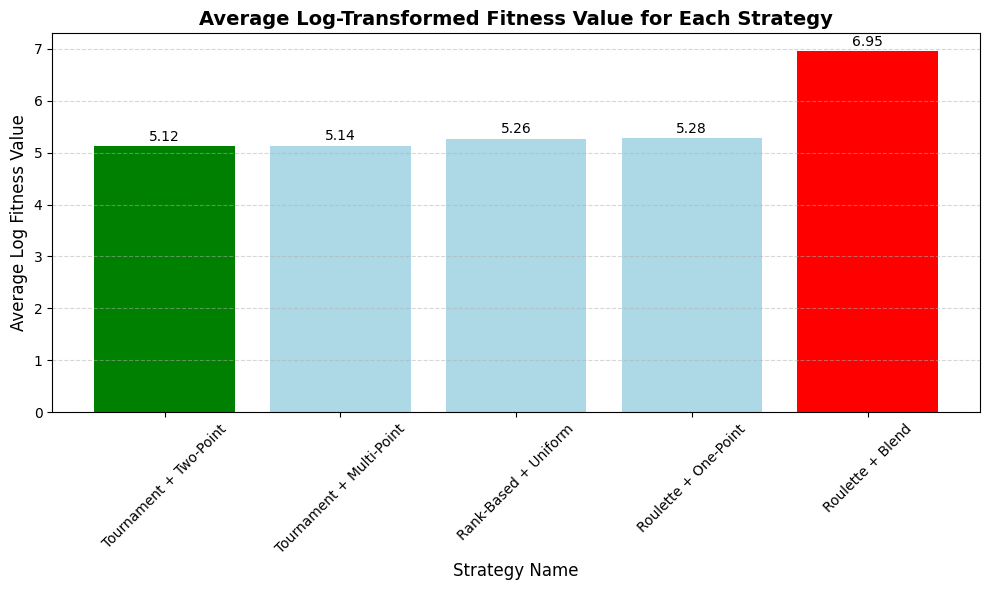

Enhanced bar chart saved to: /content/drive/MyDrive/CI/CW/Visualization/Enhanced_Log_Fitness_Strategy_BarChart.png


In [41]:

# Ensure "Best Fitness Value" is numeric
results_df["Best Fitness Value"] = pd.to_numeric(results_df["Best Fitness Value"], errors="coerce")

# Apply logarithmic transformation to the fitness values
results_df["Log Fitness Value"] = np.log10(results_df["Best Fitness Value"] + 1)

# Calculate average log-transformed fitness for each strategy
average_log_fitness = results_df.groupby("Strategy Name")["Log Fitness Value"].mean().sort_values()

# Determine the best and worst strategies
best_strategy = average_log_fitness.idxmin()
worst_strategy = average_log_fitness.idxmax()

# Plot bar chart
plt.figure(figsize=(10, 6))

# Color coding: Green for best, red for worst, blue for others
bar_colors = ['green' if strategy == best_strategy else
              'red' if strategy == worst_strategy else 'lightblue'
              for strategy in average_log_fitness.index]

bars = plt.bar(average_log_fitness.index, average_log_fitness.values, color=bar_colors)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10)

# Customize the plot
plt.title("Average Log-Transformed Fitness Value for Each Strategy", fontsize=14, weight='bold')
plt.xlabel("Strategy Name", fontsize=12)
plt.ylabel("Average Log Fitness Value", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Ensure the output directory exists
output_dir = "/content/drive/MyDrive/CI/CW/Visualization/"
os.makedirs(output_dir, exist_ok=True)

# Save the plot
output_path = os.path.join(output_dir, "Enhanced_Log_Fitness_Strategy_BarChart.png")
plt.savefig(output_path, bbox_inches="tight")
plt.show()

print(f"Enhanced bar chart saved to: {output_path}")


In [46]:
print("Columns in results_df:", results_df.columns)
print(results_df.head())


Columns in results_df: Index(['Strategy Name', 'Best Fitness Value', 'Generations', 'Population',
       'Log Fitness Value'],
      dtype='object')
              Strategy Name  Best Fitness Value  Generations  Population  Log Fitness Value
0    Tournament + Two-Point       143172.812153           50          50           5.155864
1          Roulette + Blend       197391.253703           50          50           5.295330
2      Rank-Based + Uniform       182383.548420           50          50           5.260988
3  Tournament + Multi-Point       148500.280692           50          50           5.171730
4      Roulette + One-Point       188143.125547           50          50           5.274491


In [52]:
# Function to calculate convergence metrics
def calculate_convergence_metrics(strategy_data, strategy_name):
    initial_fitness = strategy_data["Log Fitness Value"].iloc[0]
    final_fitness = strategy_data["Log Fitness Value"].iloc[-1]
    convergence_speed = ((initial_fitness - final_fitness) / initial_fitness) * 100

    # Find generation where fitness stabilizes (threshold: small changes)
    fitness_diff = strategy_data["Log Fitness Value"].diff().abs()
    stabilization_gen = fitness_diff[fitness_diff < 0.01].index.min()
    # stabilization_gen = strategy_data.iloc[stabilization_gen]["Generations"] if not np.isnan(stabilization_gen) else "Not Stabilized"

    return initial_fitness, final_fitness, convergence_speed, stabilization_gen

# Calculate for Best and Worst Strategies
best_initial, best_final, best_speed, best_stabilize = calculate_convergence_metrics(best_data, best_strategy)
worst_initial, worst_final, worst_speed, worst_stabilize = calculate_convergence_metrics(worst_data, worst_strategy)

# Print results
print(f"Best Strategy: {best_strategy}")
print(f"  - Initial Fitness: {best_initial:.2f}")
print(f"  - Final Fitness: {best_final:.2f}")
print(f"  - Convergence Speed: {best_speed:.2f}%")

print(f"\nWorst Strategy: {worst_strategy}")
print(f"  - Initial Fitness: {worst_initial:.2f}")
print(f"  - Final Fitness: {worst_final:.2f}")
print(f"  - Convergence Speed: {worst_speed:.2f}%")


Best Strategy: Tournament + Two-Point
  - Initial Fitness: 5.16
  - Final Fitness: 5.10
  - Convergence Speed: 1.18%

Worst Strategy: Roulette + Blend
  - Initial Fitness: 5.30
  - Final Fitness: 9.47
  - Convergence Speed: -78.89%


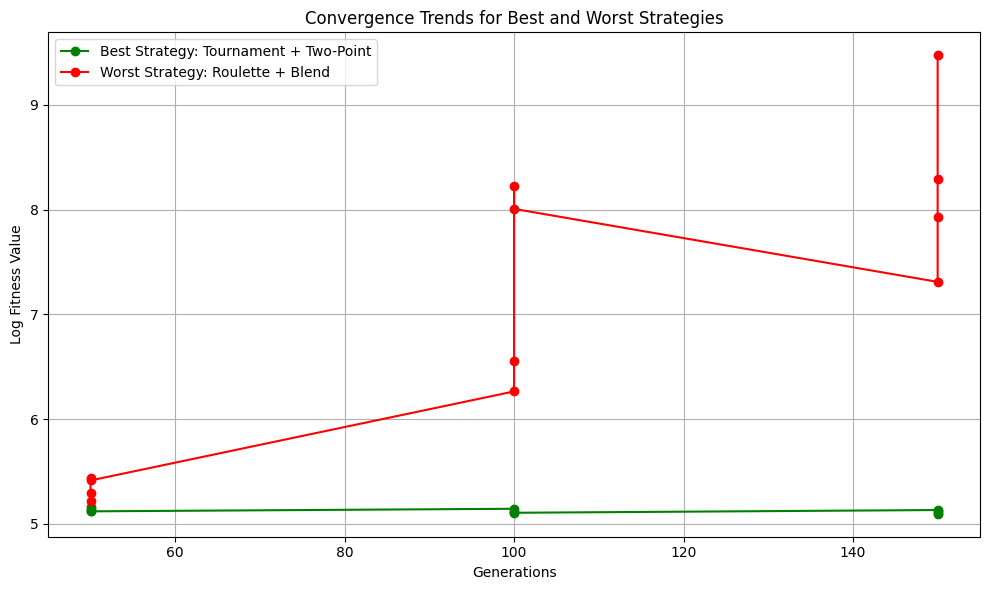

In [54]:
# Ensure data is sorted by generations for correct plotting
best_data = best_data.sort_values(by="Generations")
worst_data = worst_data.sort_values(by="Generations")

plt.figure(figsize=(10, 6))
plt.plot(best_data["Generations"], best_data["Log Fitness Value"], label=f"Best Strategy: {best_strategy}", marker='o', color="green")
plt.plot(worst_data["Generations"], worst_data["Log Fitness Value"], label=f"Worst Strategy: {worst_strategy}", marker='o', color="red")
plt.xlabel("Generations")
plt.ylabel("Log Fitness Value")
plt.title("Convergence Trends for Best and Worst Strategies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

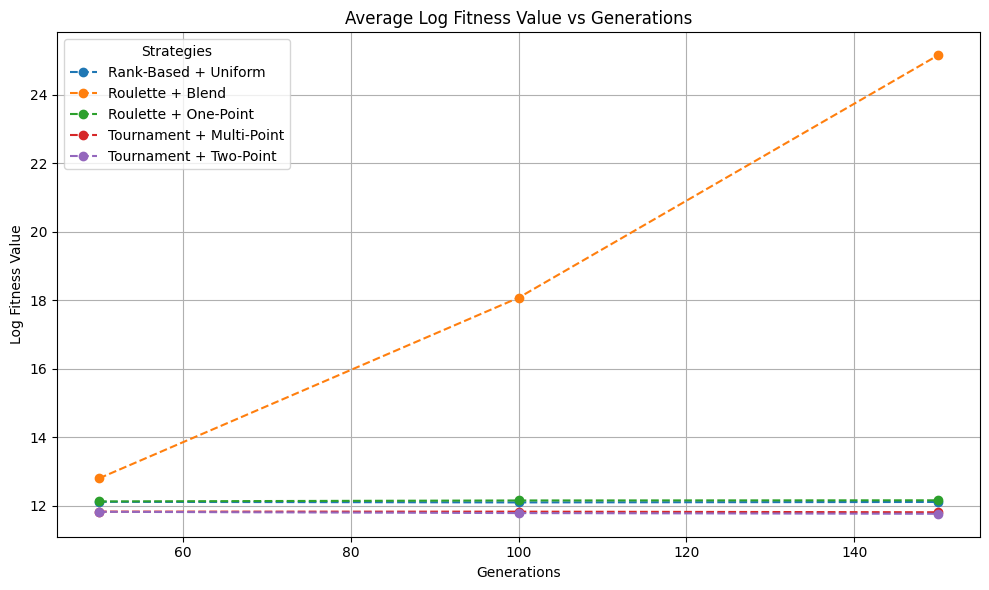

In [ ]:
# Group by Strategy and Generations, then calculate mean fitness
avg_fitness = results_df.groupby(["Strategy Name", "Generations"])["Best Fitness Value"].mean().reset_index()

# Plot line curves for each strategy
plt.figure(figsize=(10, 6))
for strategy in avg_fitness["Strategy Name"].unique():
    strategy_data = avg_fitness[avg_fitness["Strategy Name"] == strategy]
    plt.plot(strategy_data["Generations"], np.log(strategy_data["Best Fitness Value"]),
             marker="o", linestyle="--", label=strategy)

plt.title("Average Log Fitness Value vs Generations")
plt.xlabel("Generations")
plt.ylabel("Log Fitness Value")
plt.legend(title="Strategies")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Print column names for debugging
print("Available Columns:", results_df.columns)

Available Columns: Index(['Strategy Name', 'Best Fitness Value', 'Convergence Speed (%)',
       'Population Size', 'Generations'],
      dtype='object')


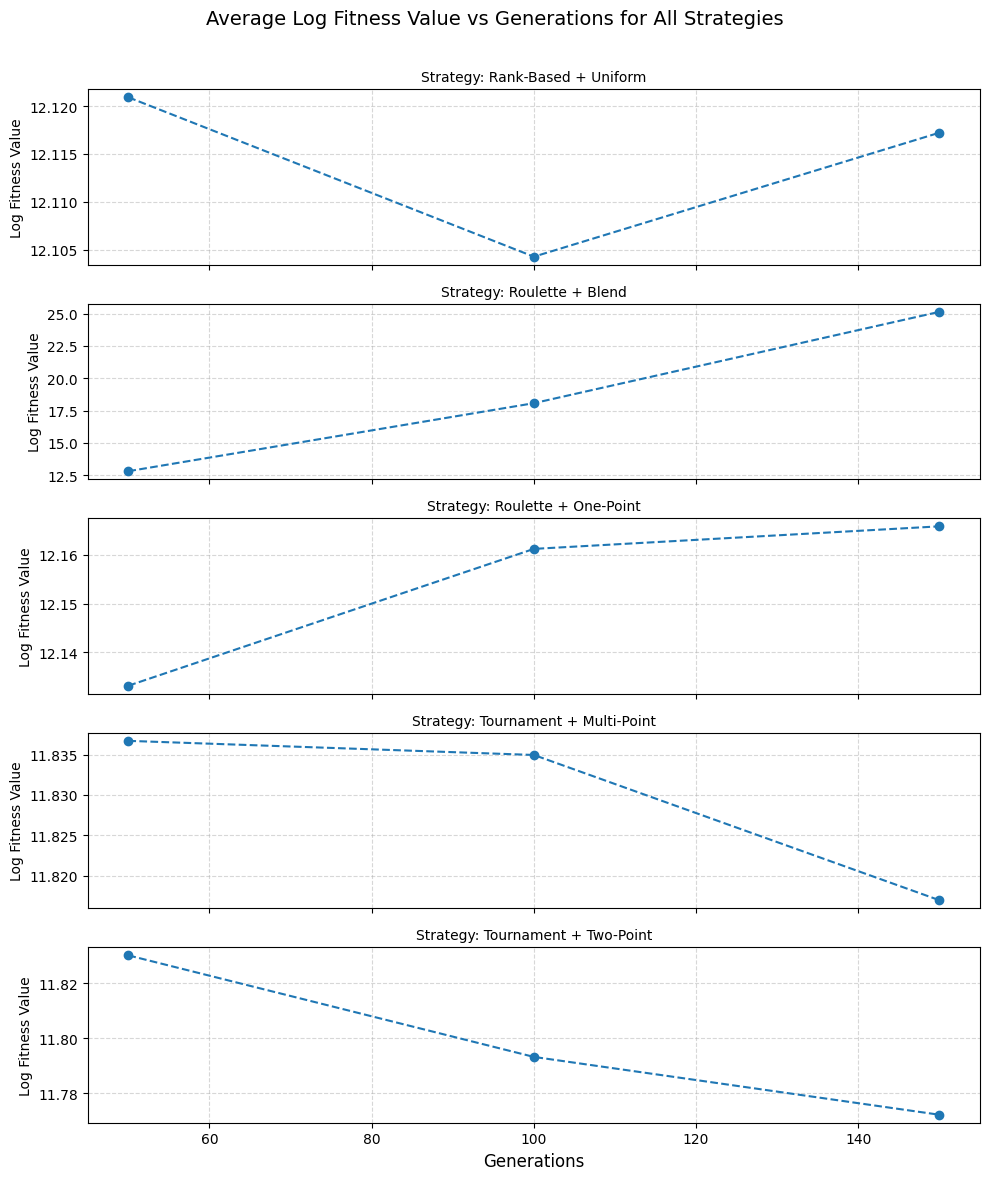

Graph saved to: /content/drive/My Drive/CI/All_Strategies_Log_Fitness_Subplots.png


In [ ]:
# Load the data
file_path = "/content/drive/My Drive/CI/best_strategy_results.csv"
column_names = ["Strategy Name", "Best Fitness Value", "Generations", "Population"]
results_df = pd.read_csv(file_path, names=column_names, header=None)

# Convert 'Best Fitness Value' to numeric, coercing invalid entries to NaN
results_df["Best Fitness Value"] = pd.to_numeric(results_df["Best Fitness Value"], errors="coerce")

# Drop rows with invalid Best Fitness Value
results_df = results_df.dropna(subset=["Best Fitness Value"])

# Ensure Generations column is numeric
results_df["Generations"] = pd.to_numeric(results_df["Generations"], errors="coerce")

# Group data by Strategy and Generations to calculate average fitness
avg_fitness = results_df.groupby(["Strategy Name", "Generations"])["Best Fitness Value"].mean().reset_index()

# Apply log transformation to the fitness values
avg_fitness["Log Fitness Value"] = np.log(avg_fitness["Best Fitness Value"])

# Plot each strategy in its own subplot
strategies = avg_fitness["Strategy Name"].unique()
fig, axes = plt.subplots(nrows=len(strategies), ncols=1, figsize=(10, 12), sharex=True)

# Generate subplots
for ax, strategy in zip(axes, strategies):
    strategy_data = avg_fitness[avg_fitness["Strategy Name"] == strategy]
    ax.plot(
        strategy_data["Generations"],
        strategy_data["Log Fitness Value"],
        marker="o",
        linestyle="--",
        color="tab:blue"
    )
    ax.set_title(f"Strategy: {strategy}", fontsize=10)
    ax.set_ylabel("Log Fitness Value", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.5)

# Final plot adjustments
plt.suptitle("Average Log Fitness Value vs Generations for All Strategies", fontsize=14)
plt.xlabel("Generations", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title

# Save and display the plot
output_path = "/content/drive/My Drive/CI/All_Strategies_Log_Fitness_Subplots.png"
plt.savefig(output_path)
plt.show()

print(f"Graph saved to: {output_path}")


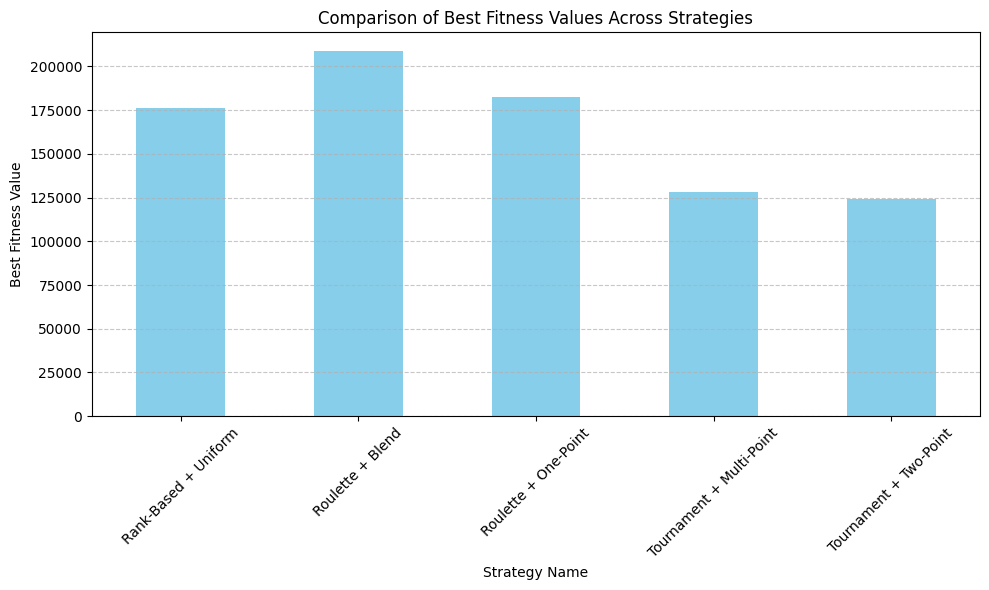

In [ ]:
# Calculate the best fitness for each strategy
best_fitness_per_strategy = results_df.groupby("Strategy Name")["Best Fitness Value"].min()

# Plot the bar chart
plt.figure(figsize=(10, 6))
best_fitness_per_strategy.plot(kind="bar", color="skyblue")

plt.title("Comparison of Best Fitness Values Across Strategies")
plt.xlabel("Strategy Name")
plt.ylabel("Best Fitness Value")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


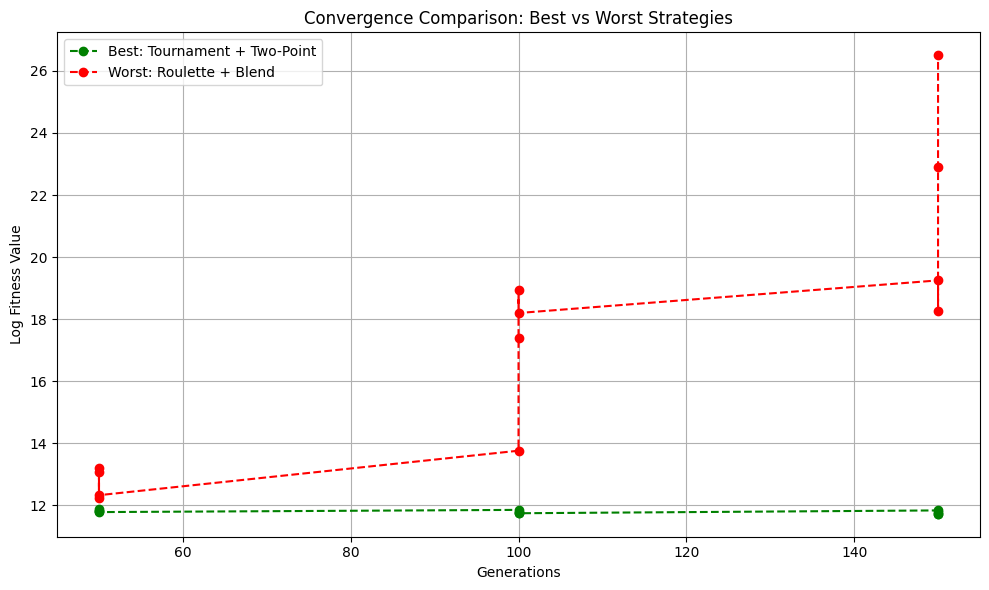

In [ ]:
# Find the best and worst strategies based on minimum fitness
strategy_fitness = results_df.groupby("Strategy Name")["Best Fitness Value"].min()
best_strategy = strategy_fitness.idxmin()
worst_strategy = strategy_fitness.idxmax()

# Filter data for best and worst strategies
best_data = results_df[results_df["Strategy Name"] == best_strategy]
worst_data = results_df[results_df["Strategy Name"] == worst_strategy]

# Plot convergence comparison
plt.figure(figsize=(10, 6))
plt.plot(best_data["Generations"], np.log(best_data["Best Fitness Value"]),
         marker="o", linestyle="--", color="green", label=f"Best: {best_strategy}")
plt.plot(worst_data["Generations"], np.log(worst_data["Best Fitness Value"]),
         marker="o", linestyle="--", color="red", label=f"Worst: {worst_strategy}")

plt.title("Convergence Comparison: Best vs Worst Strategies")
plt.xlabel("Generations")
plt.ylabel("Log Fitness Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
